## Load data and modules

In [1]:
from sentence_transformers import SentenceTransformer, util
from PIL import Image
import glob
import torch
import pickle
import zipfile
from IPython.display import display
from IPython.display import Image as IPImage
import os
from tqdm import tqdm

2023-03-19 19:01:22.394367: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


This loads a list of all the image ids

In [2]:
img_names = []
with open('/scratch/leuven/338/vsc33847/TEAM_3/img_ids.txt') as in_file:
    for line in in_file:
        line = line.strip()
        img_names.append(line)

This is a matrix contaning the CLIP embeddings for all the 35K+ images, put on the GPU

In [3]:
emb_matrix = torch.load('/scratch/leuven/338/vsc33847/TEAM_3/clip_emb_matrix.pt', map_location=lambda storage, loc: storage)

## Image clustering

Function to detect clusters with images close together in embedding space (from sentencetransformers)

In [4]:
def community_detection(embeddings, threshold, min_community_size=10, init_max_size=1000):
    """
    Function for Fast Community Detection

    Finds in the embeddings all communities, i.e. embeddings that are close (closer than threshold).

    Returns only communities that are larger than min_community_size. The communities are returned
    in decreasing order. The first element in each list is the central point in the community.
    """

    # Compute cosine similarity scores
    cos_scores = util.cos_sim(embeddings, embeddings)

    # Minimum size for a community
    top_k_values, _ = cos_scores.topk(k=min_community_size, largest=True)

    # Filter for rows >= min_threshold
    extracted_communities = []
    for i in range(len(top_k_values)):
        if top_k_values[i][-1] >= threshold:
            new_cluster = []

            # Only check top k most similar entries
            top_val_large, top_idx_large = cos_scores[i].topk(k=init_max_size, largest=True)
            top_idx_large = top_idx_large.tolist()
            top_val_large = top_val_large.tolist()

            if top_val_large[-1] < threshold:
                for idx, val in zip(top_idx_large, top_val_large):
                    if val < threshold:
                        break

                    new_cluster.append(idx)
            else:
                # Iterate over all entries (slow)
                for idx, val in enumerate(cos_scores[i].tolist()):
                    if val >= threshold:
                        new_cluster.append(idx)

            extracted_communities.append(new_cluster)

    # Largest cluster first
    extracted_communities = sorted(extracted_communities, key=lambda x: len(x), reverse=True)

    # Step 2) Remove overlapping communities
    unique_communities = []
    extracted_ids = set()

    for community in extracted_communities:
        add_cluster = True
        for idx in community:
            if idx in extracted_ids:
                add_cluster = False
                break

        if add_cluster:
            unique_communities.append(community)
            for idx in community:
                extracted_ids.add(idx)

    return unique_communities

Carry out clustering and save result

In [5]:
clusters = community_detection(emb_matrix, threshold=0.9, min_community_size=10)
print("Total number of clusters:", len(clusters))

Total number of clusters: 183


Next line will output the first 10 (largest) clusters, each with three example images from the dataset



Cluster size: 561


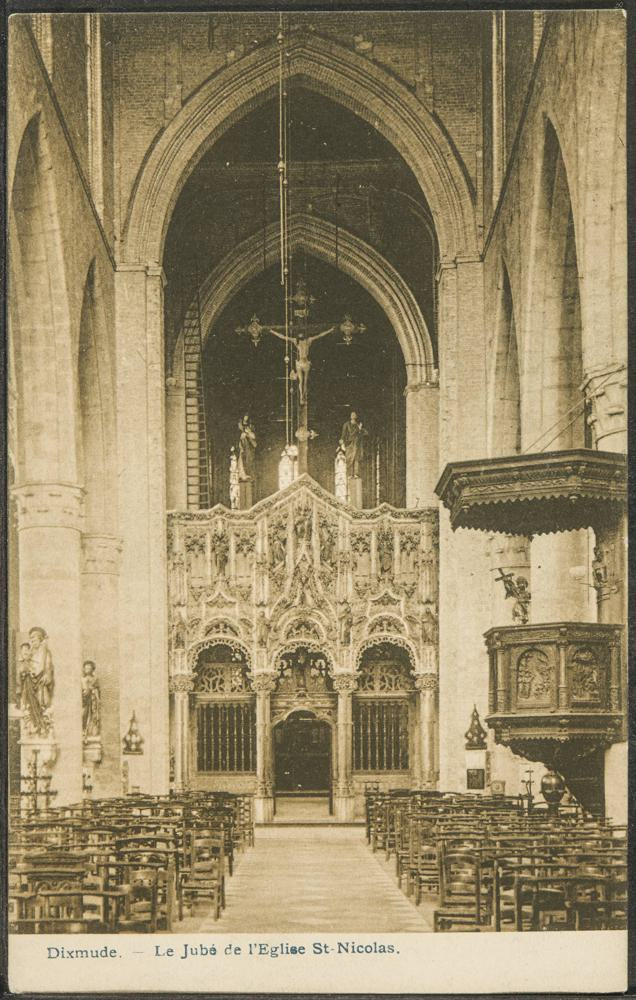

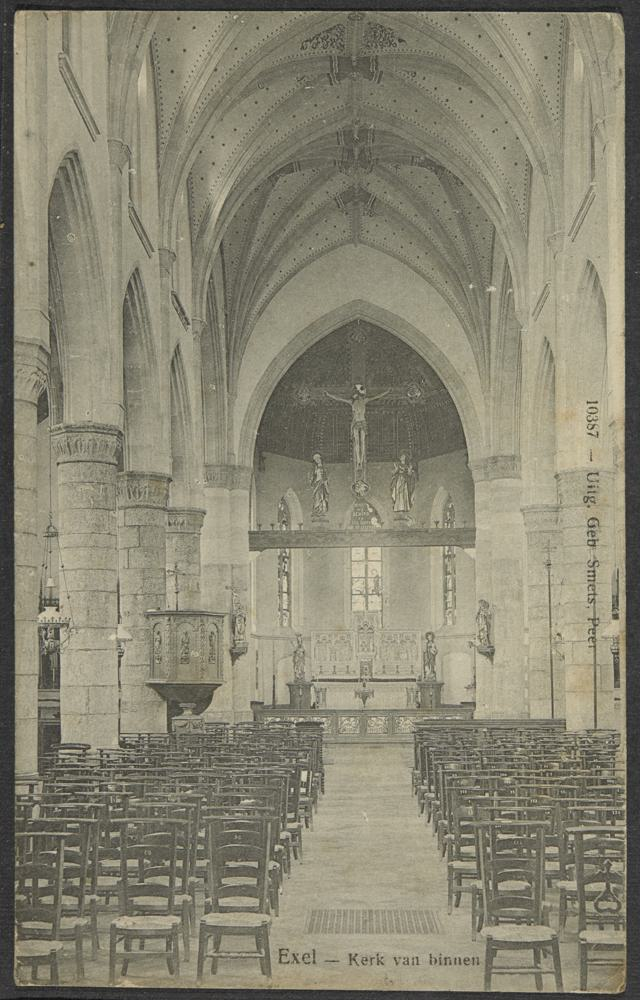

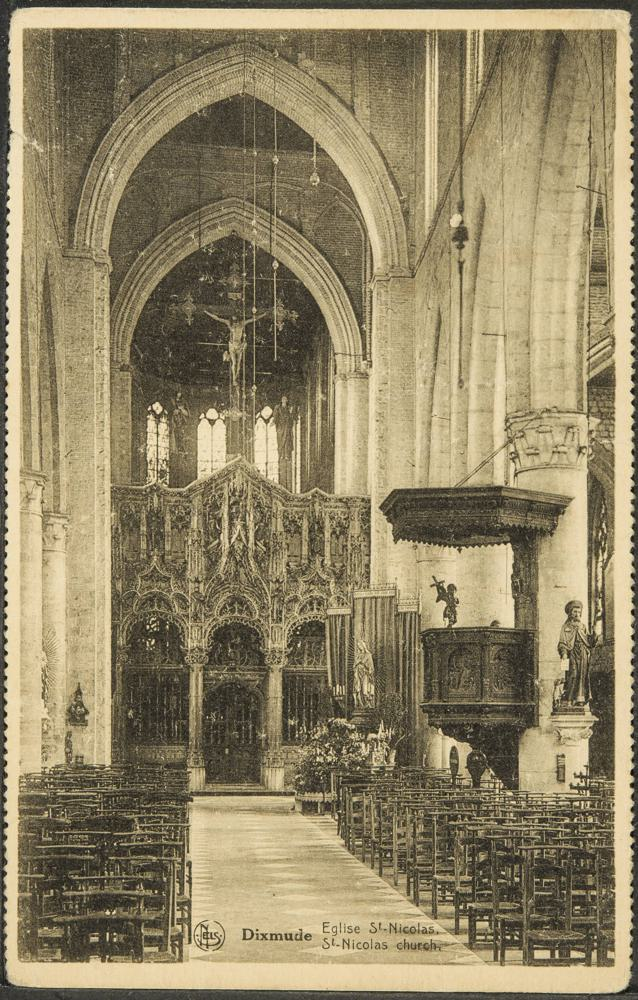



Cluster size: 284


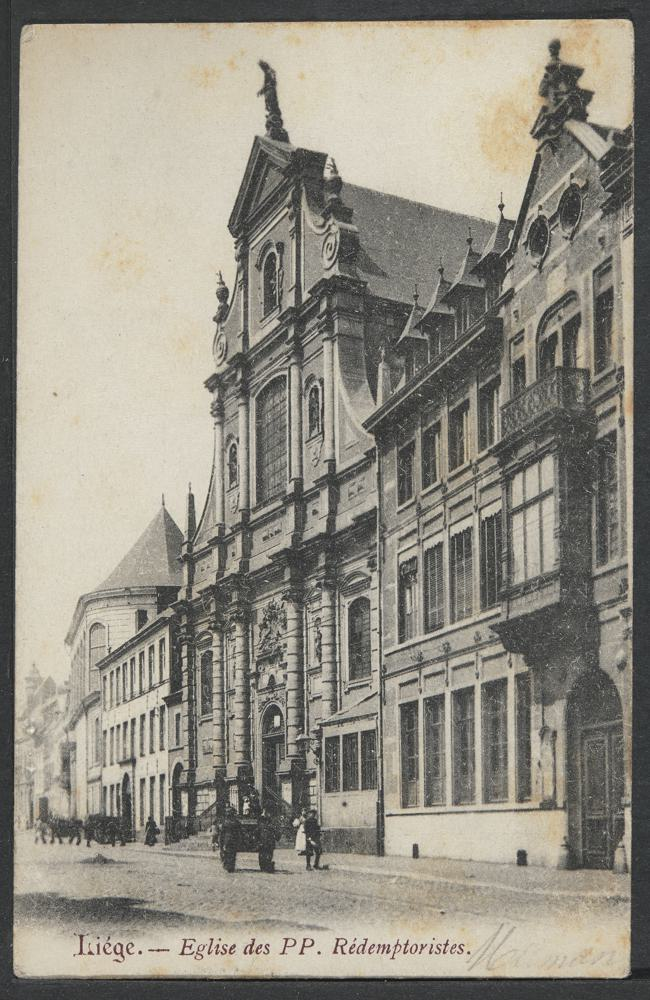

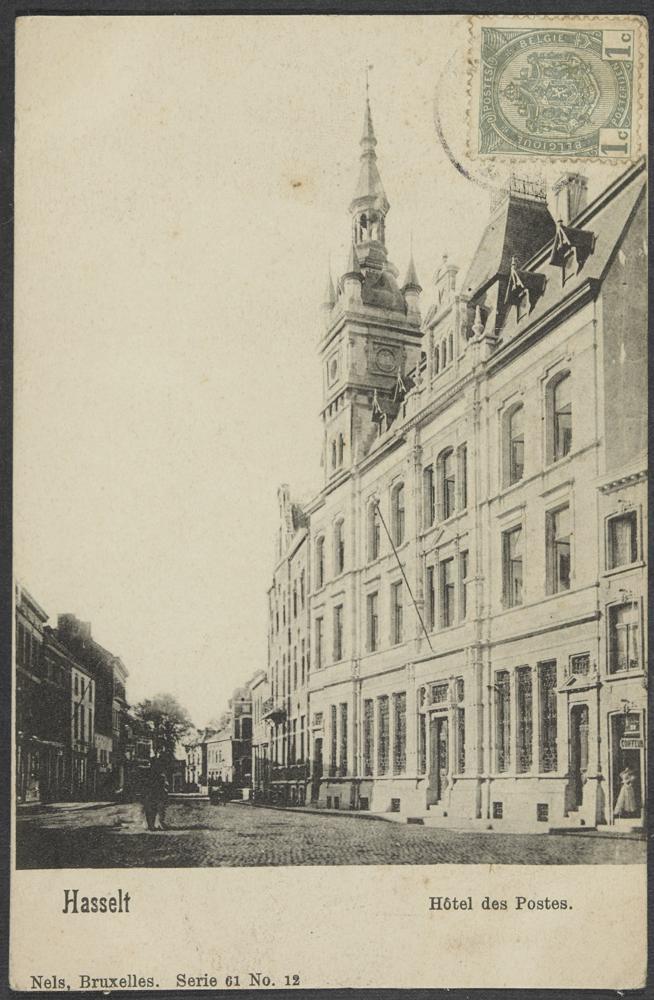

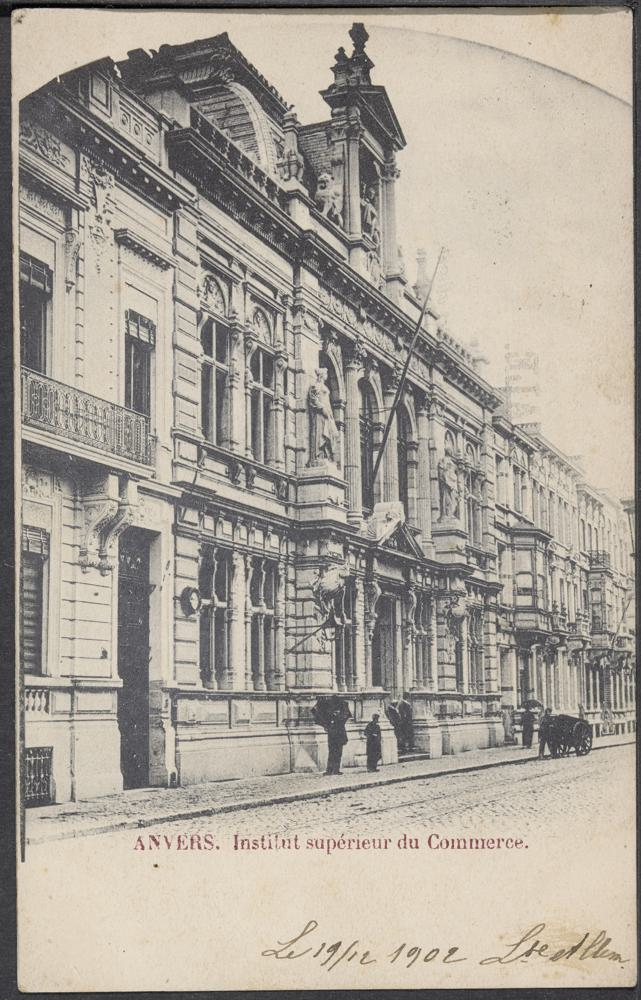



Cluster size: 202


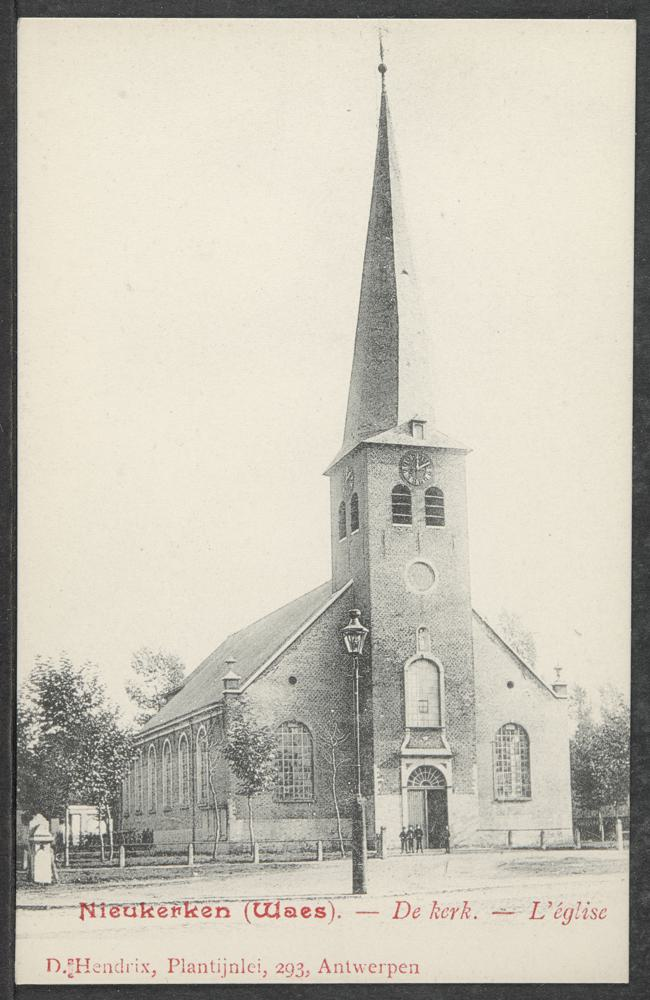

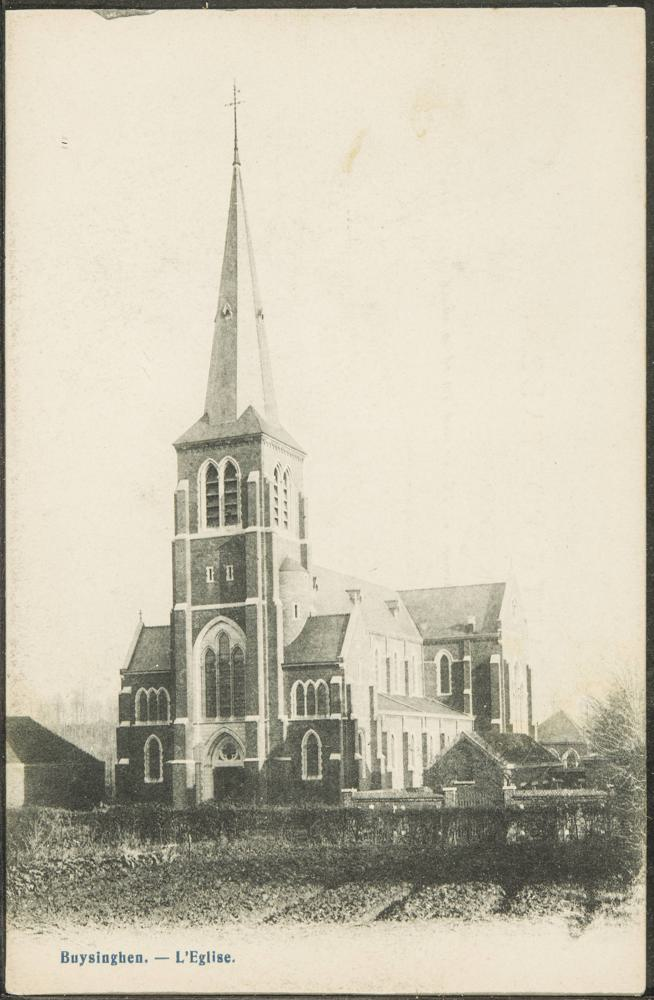

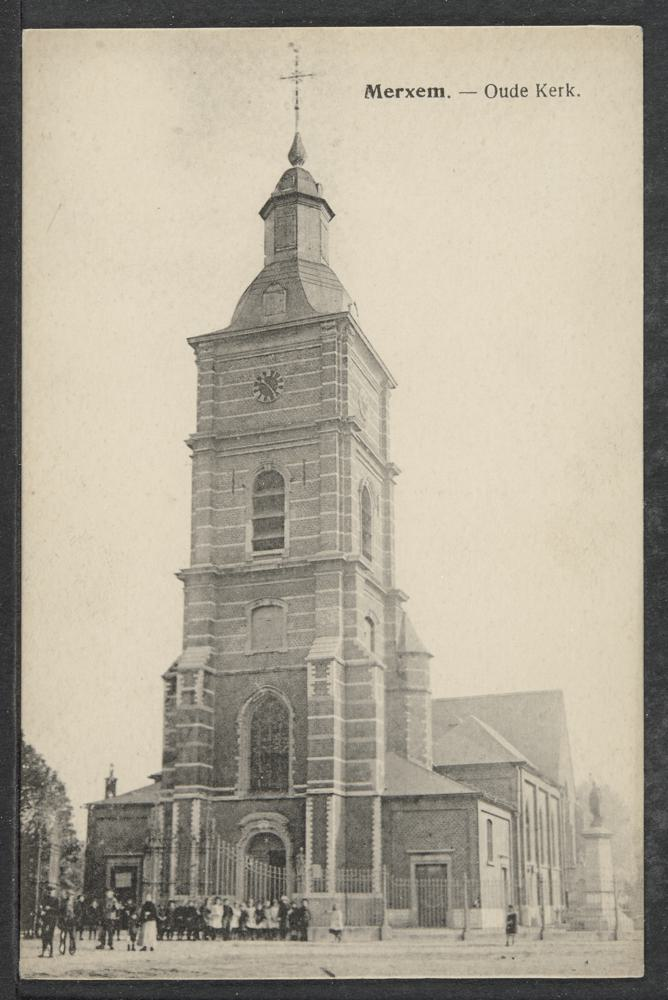



Cluster size: 200


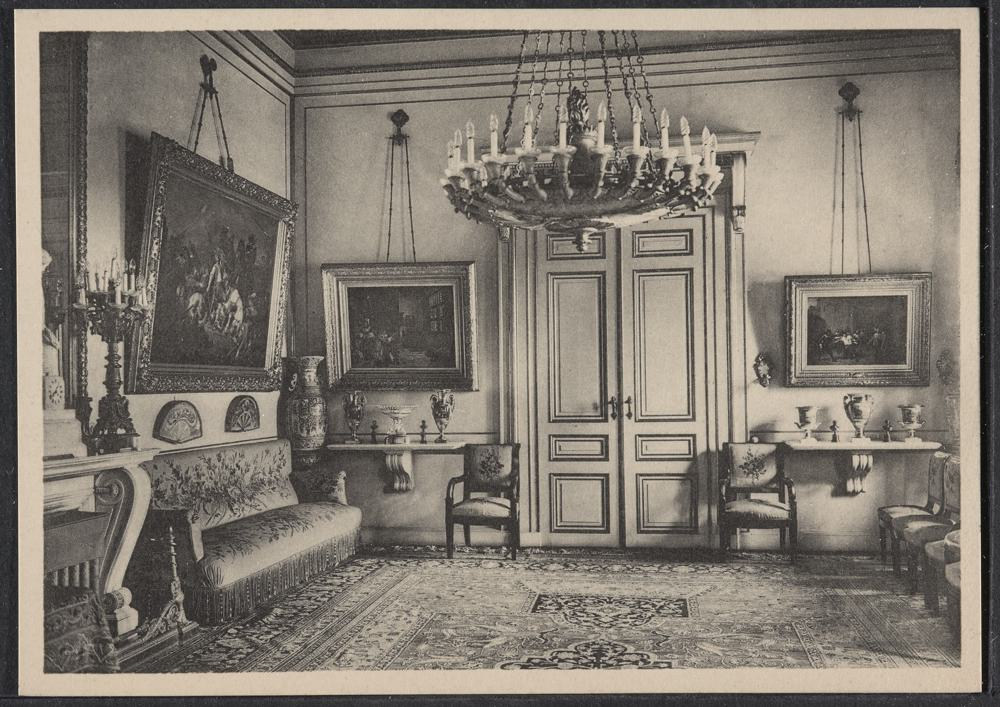

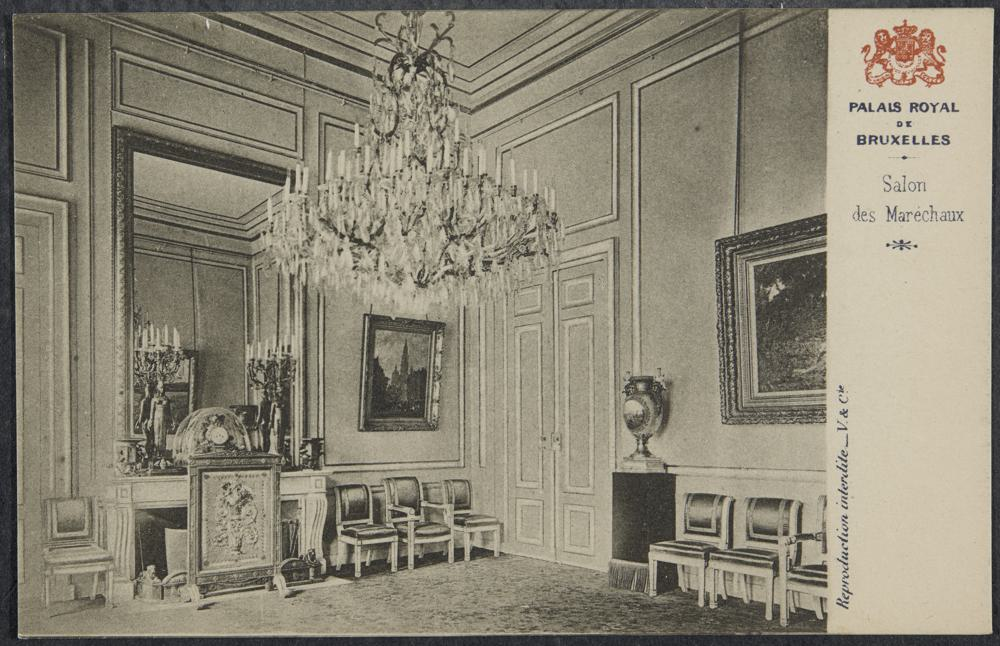

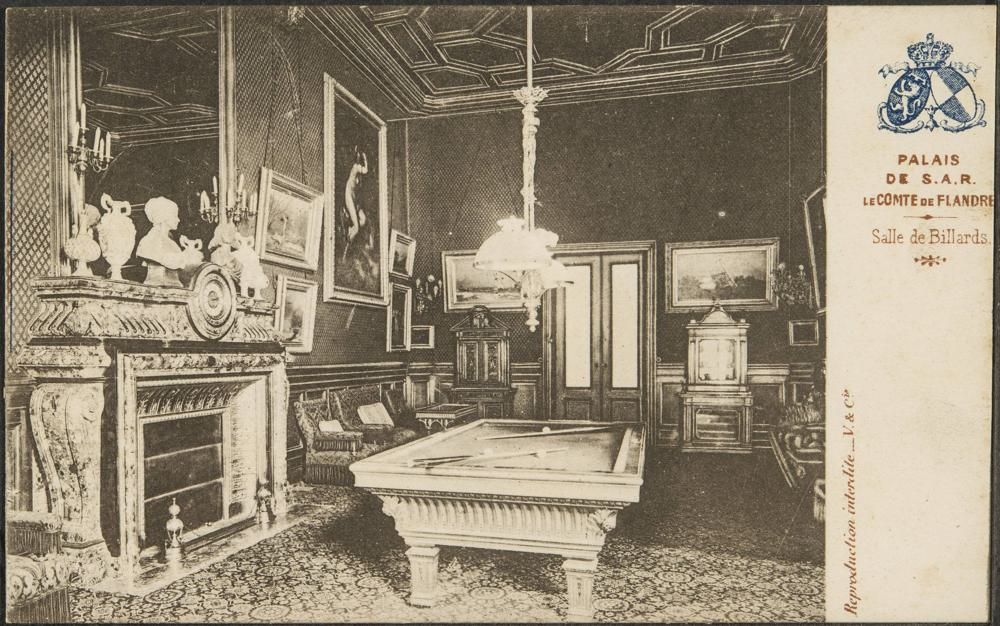



Cluster size: 184


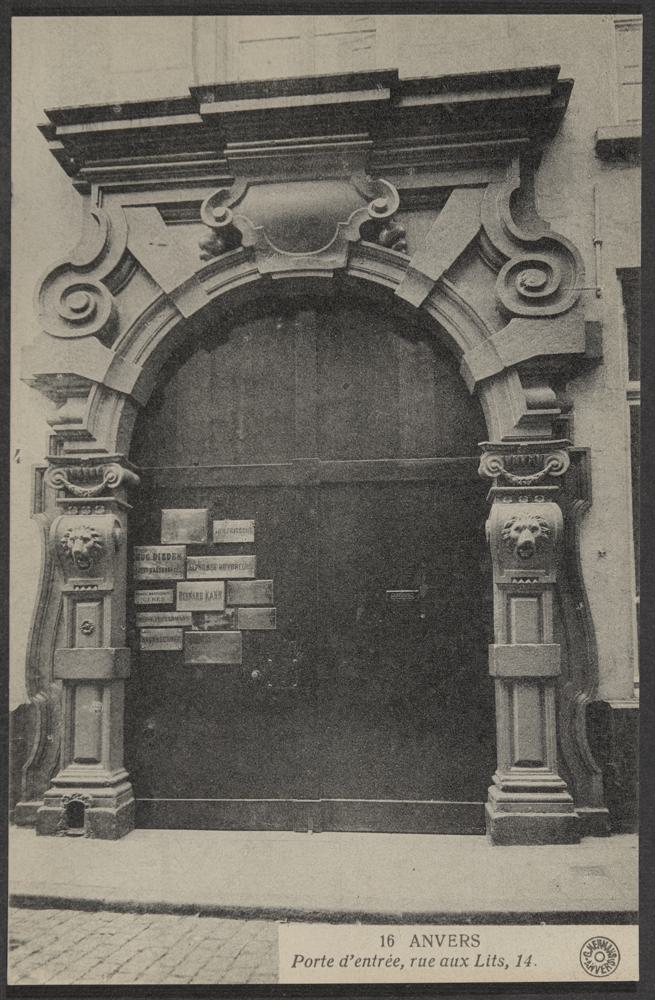

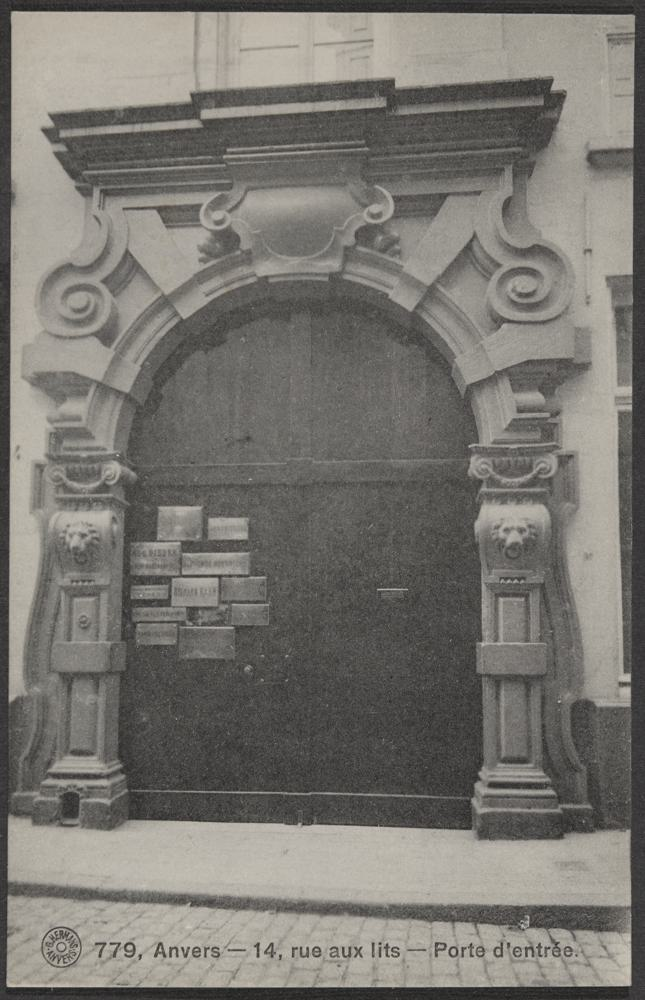

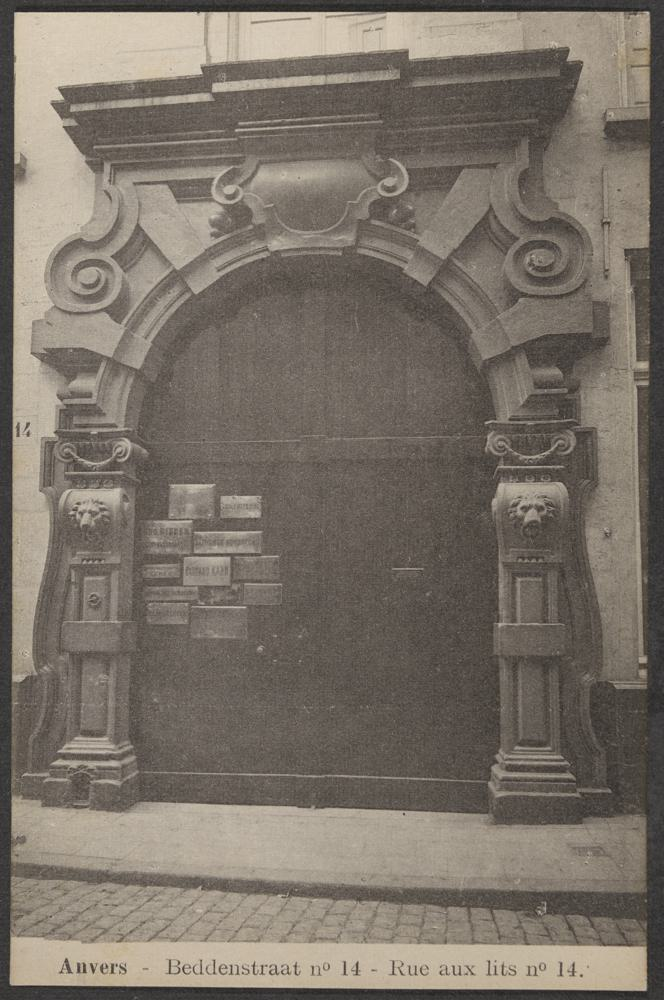



Cluster size: 135


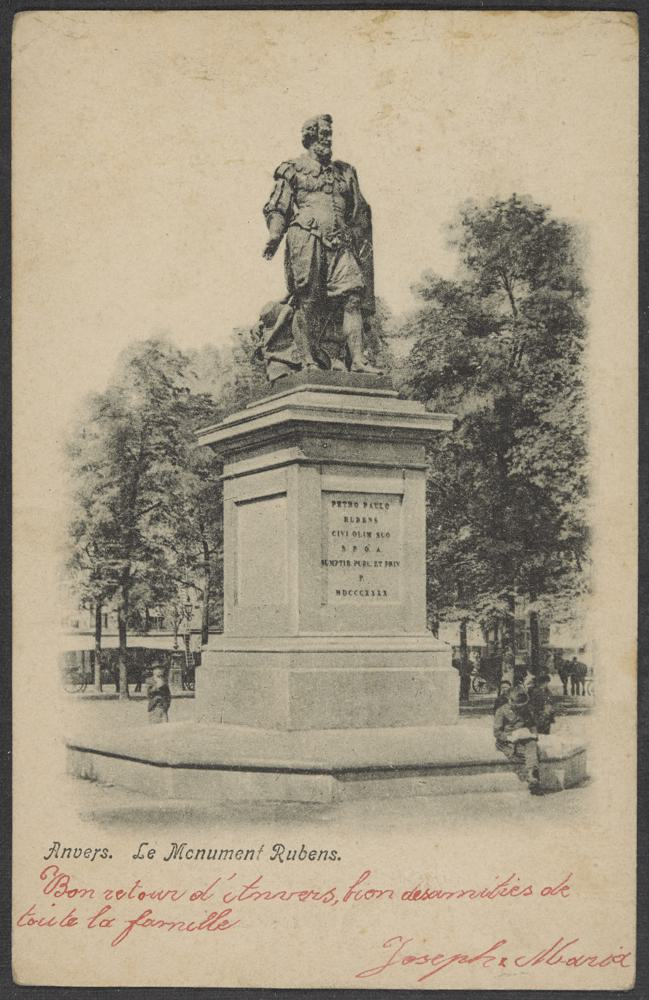

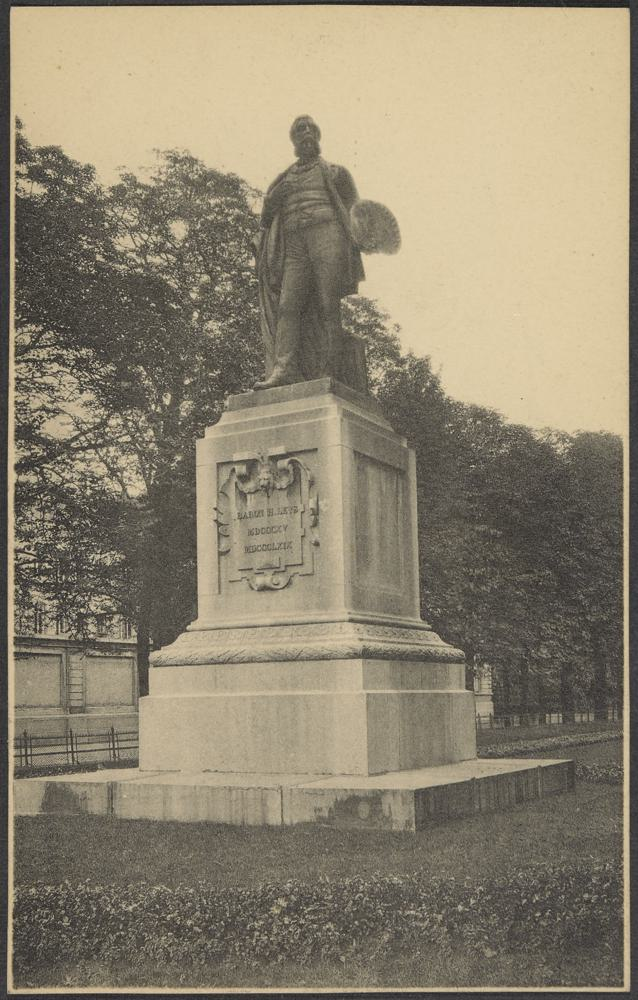

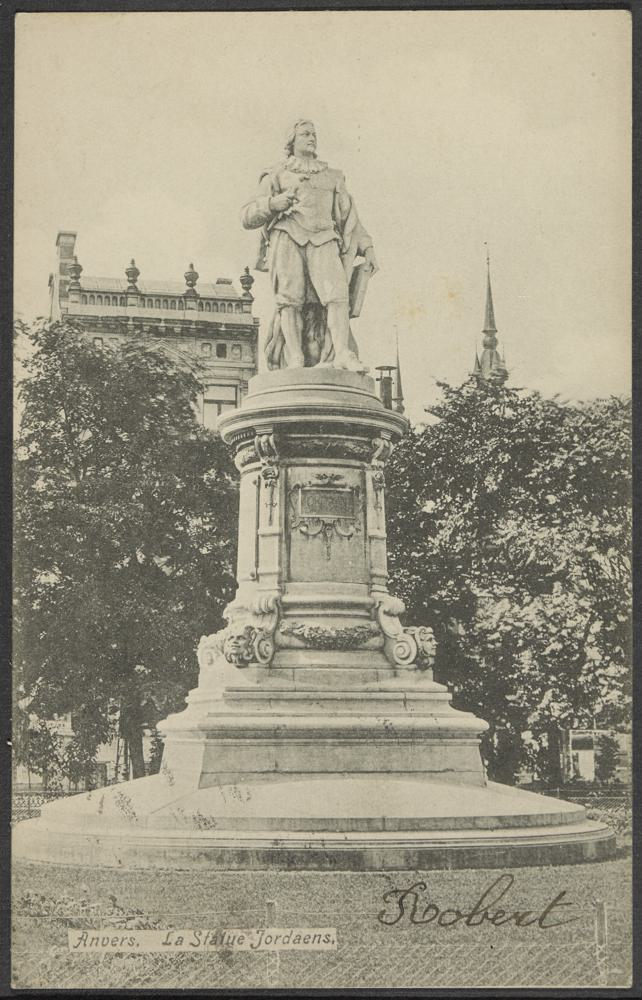



Cluster size: 126


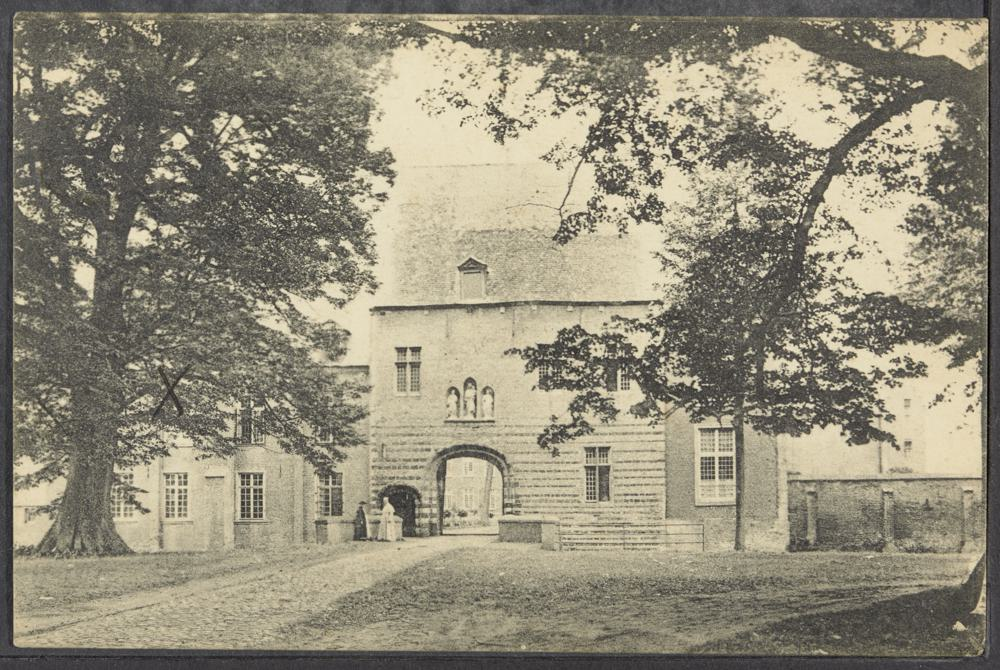

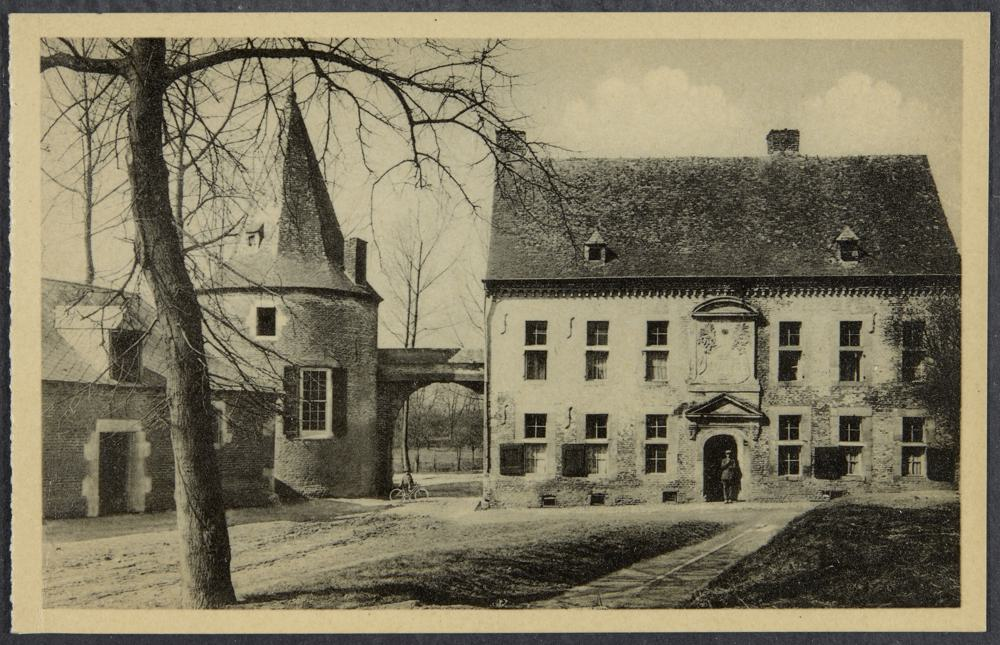

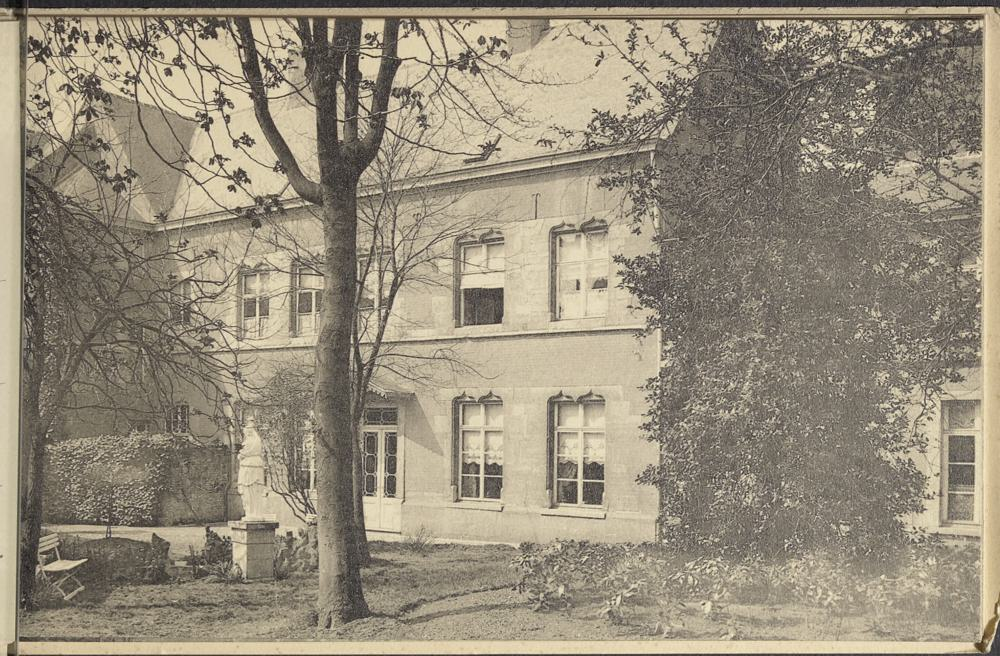



Cluster size: 120


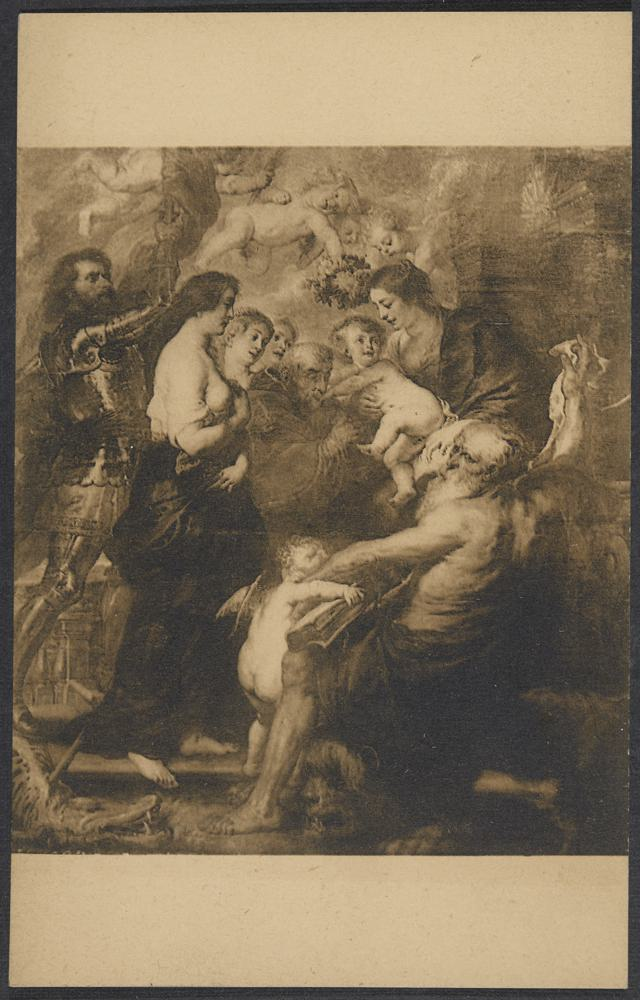

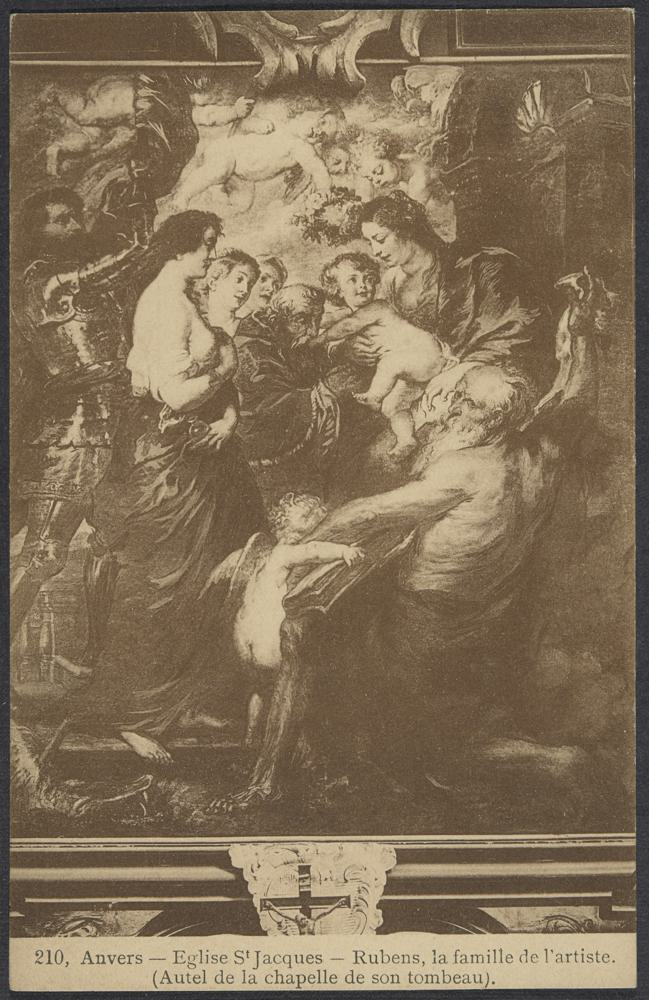

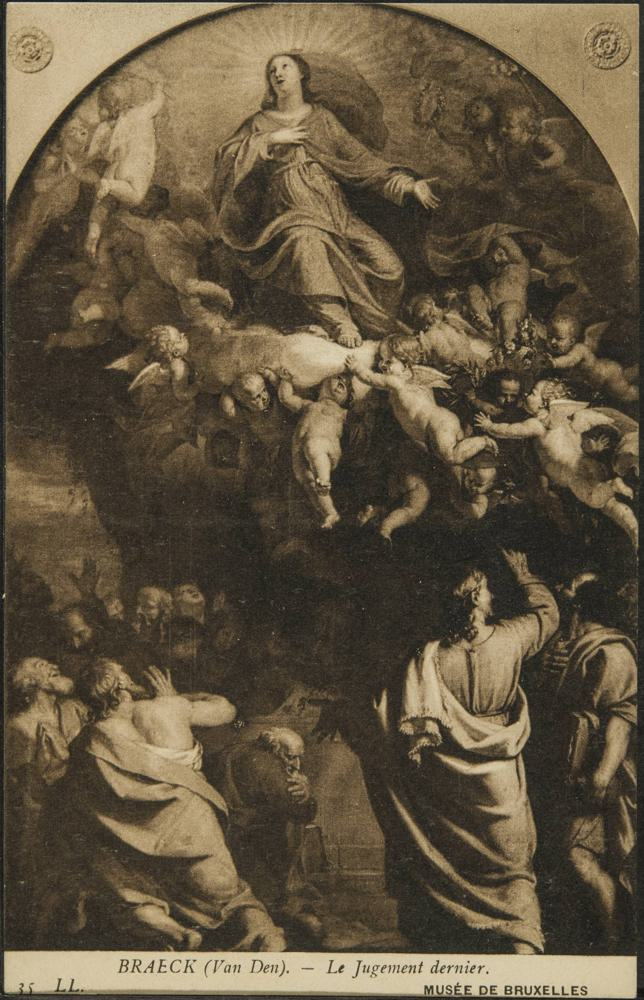



Cluster size: 105


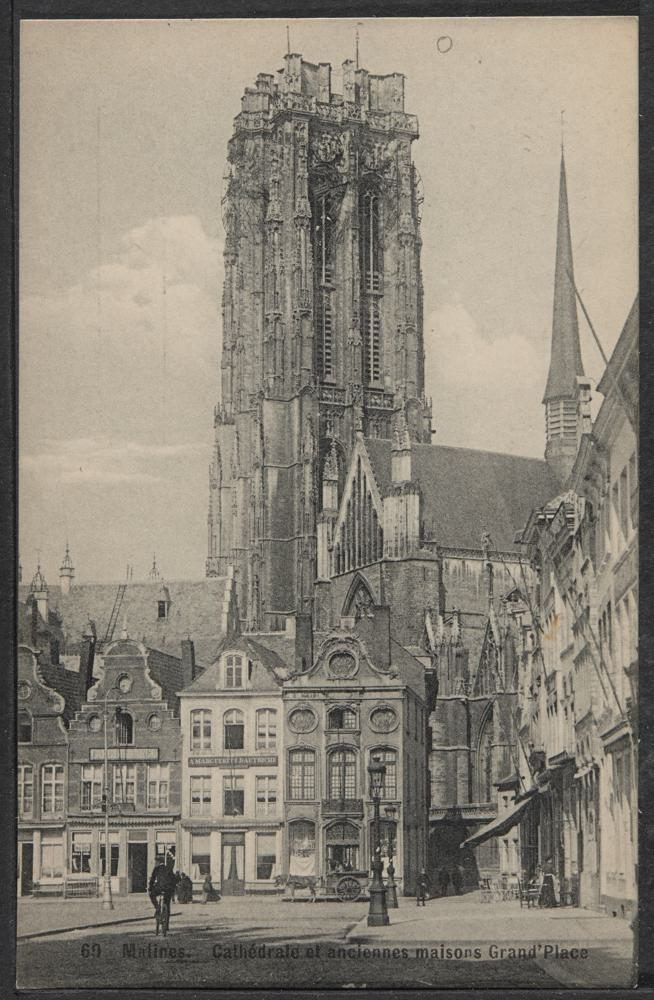

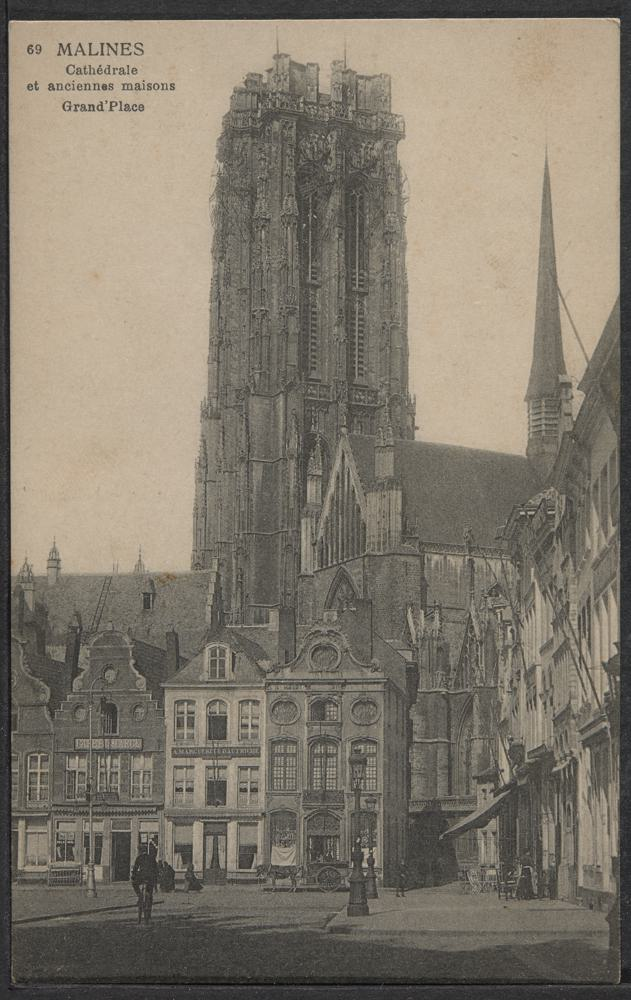

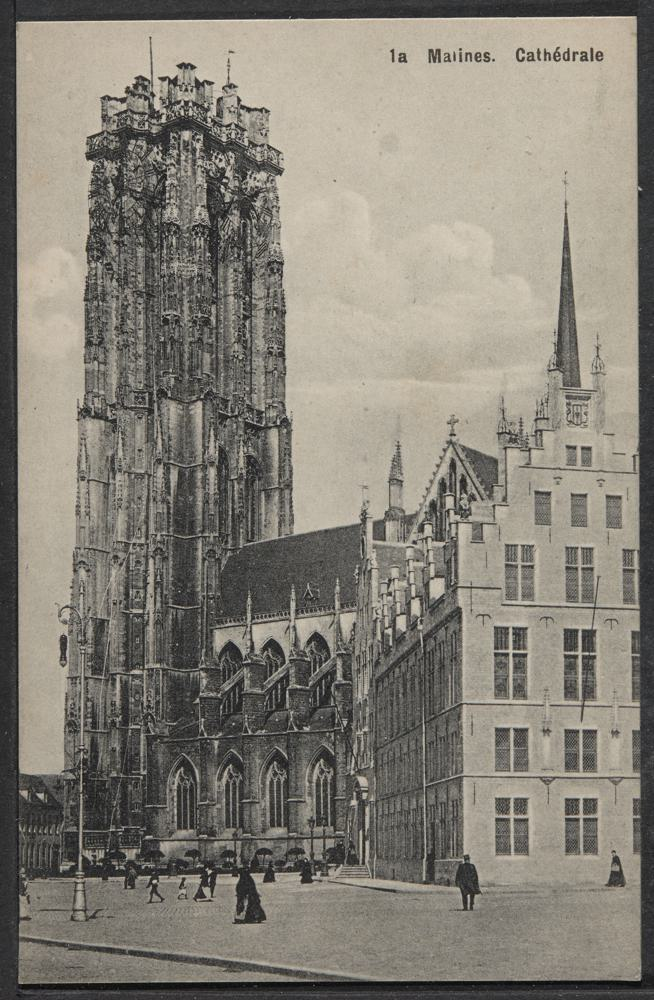



Cluster size: 73


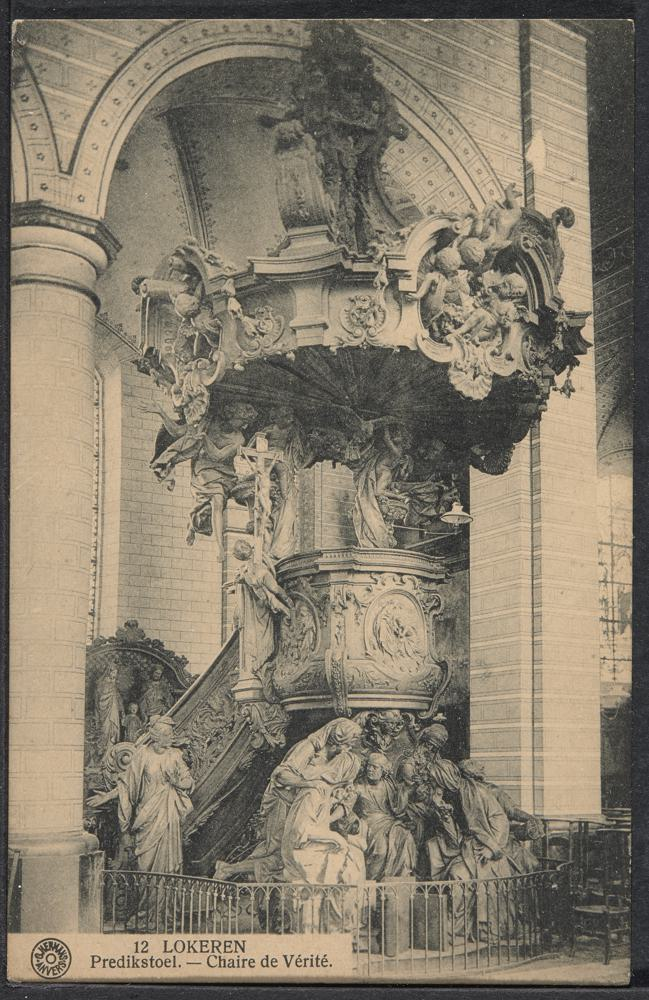

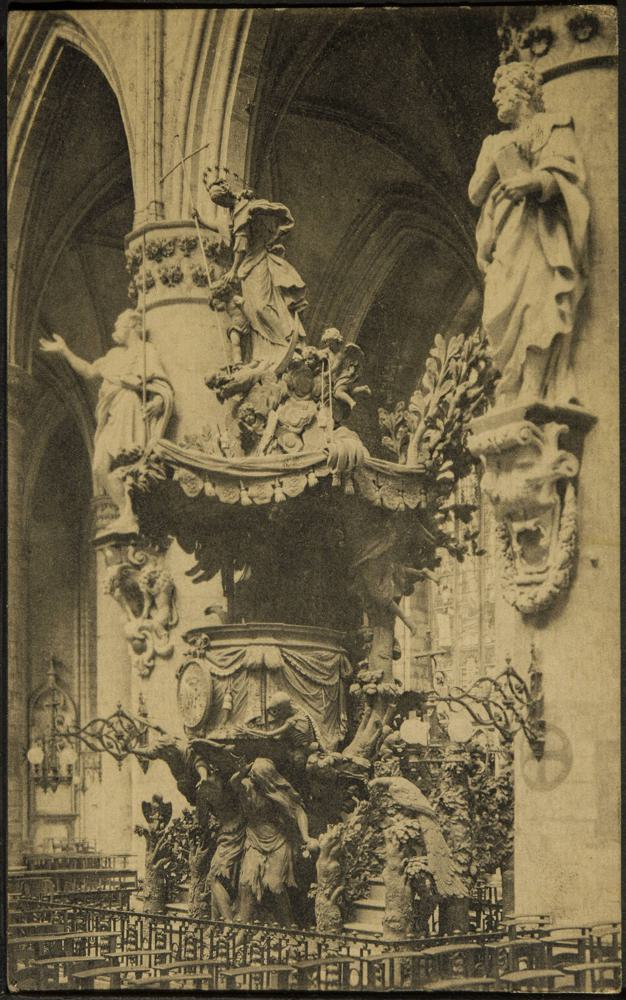

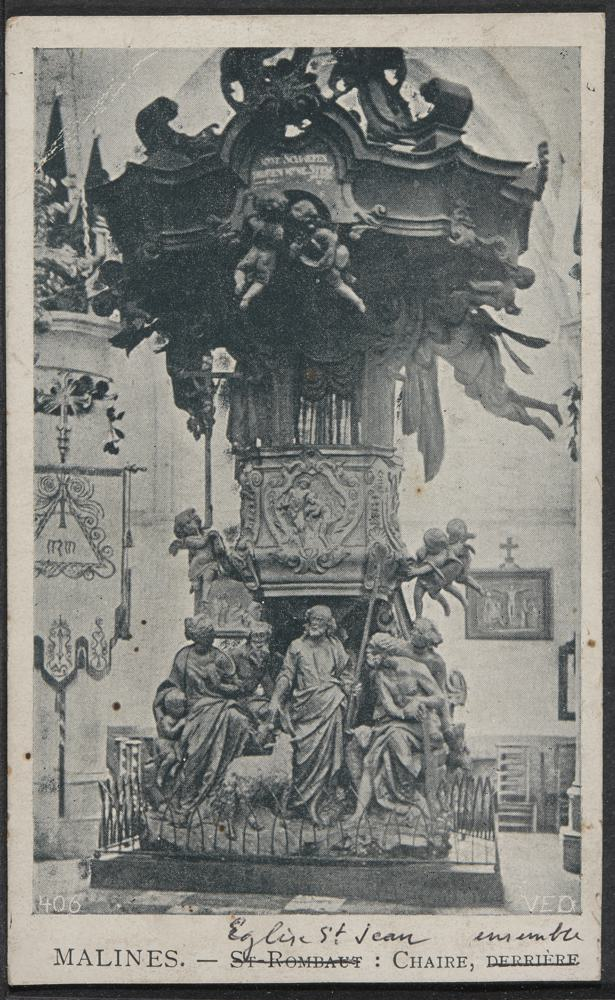

In [6]:

for cluster in clusters[0:10]:
    print("\n\nCluster size:", len(cluster))
    
    #Output 3 images
    for idx in cluster[0:3]:
        display(IPImage(img_names[idx], width=300))

## Semantic image search

Load a multilingual CLIP model, that will be used to encode text into CLIP embedding

In [7]:
model_multi = SentenceTransformer('clip-ViT-B-32-multilingual-v1')

This is the function for the semantic search 

In [8]:
# Next, we define a search function.
def search(query, k=3):
    # First, we encode the query (which can either be an image or a text string)
    query_emb = model_multi.encode([query], convert_to_tensor=True, show_progress_bar=False)
    
    # Then, we use the util.semantic_search function, which computes the cosine-similarity
    # between the query embedding and all image embeddings.
    # It then returns the top_k highest ranked images, which we output
    hits = util.semantic_search(query_emb, emb_matrix, top_k=k)[0]
    
    print("Query:")
    display(query)
    for hit in hits:
        print(img_names[hit['corpus_id']])
        display(IPImage(img_names[hit['corpus_id']], width=500))


Query:


'beautiful nature'

/scratch/leuven/338/vsc33847/DATASET_3/IE14595693/REP14595699/FL14595700_DIGI_0020_084643_R.tif.LQ.small.jpg


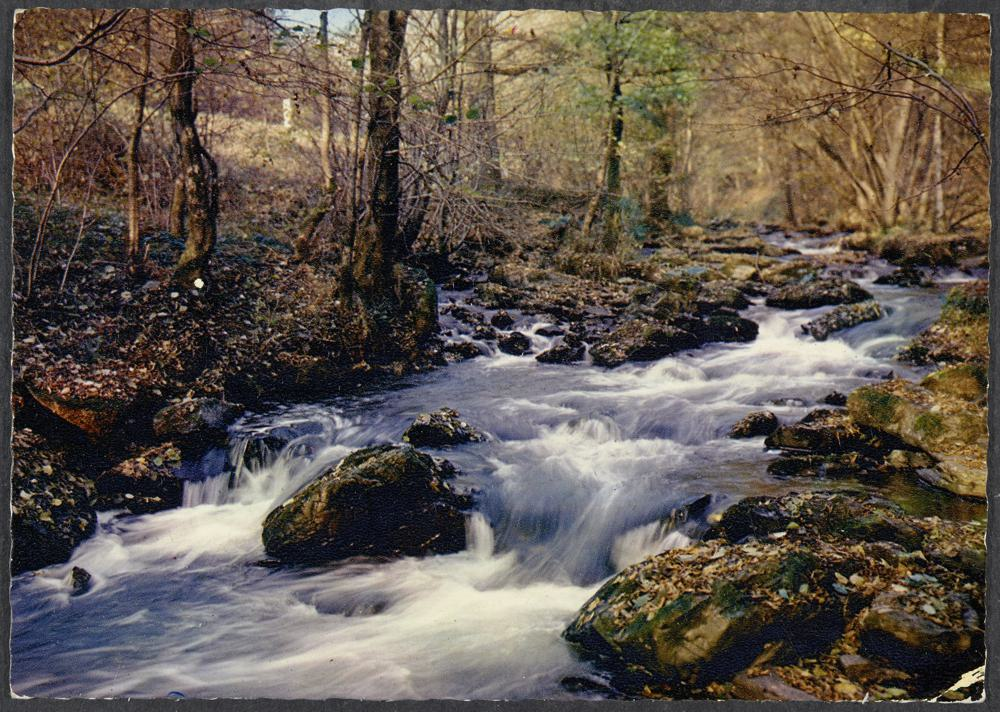

/scratch/leuven/338/vsc33847/DATASET_3/IE11100157/REP11100171/FL11100173_DIGI_0020_072046_R.tif.LQ.small.jpg


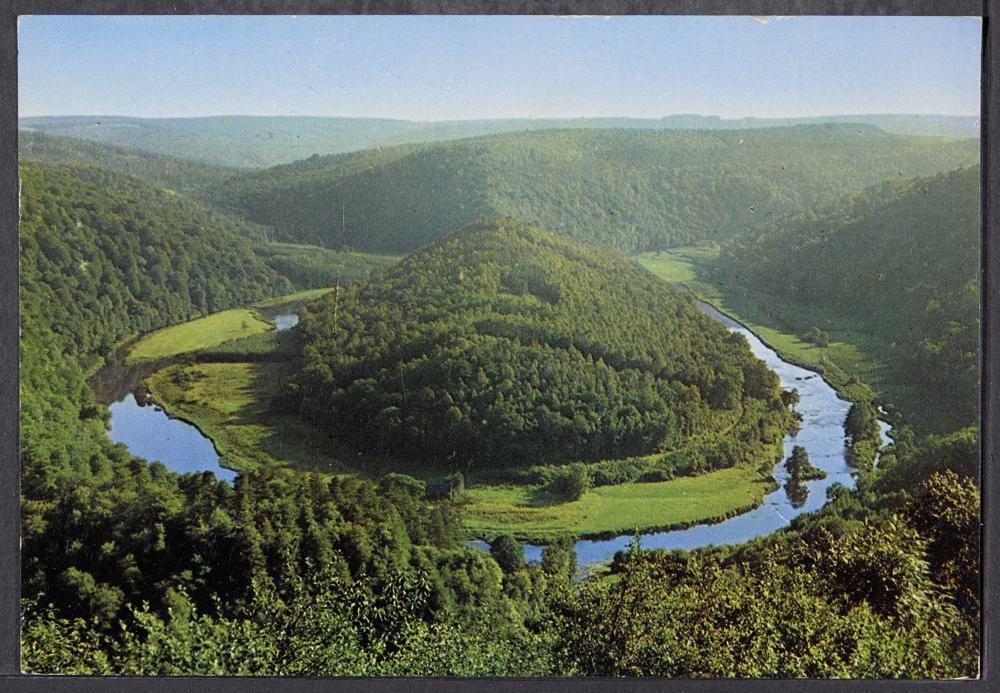

/scratch/leuven/338/vsc33847/DATASET_3/IE14595680/REP14595685/FL14595686_DIGI_0020_084642_R.tif.LQ.small.jpg


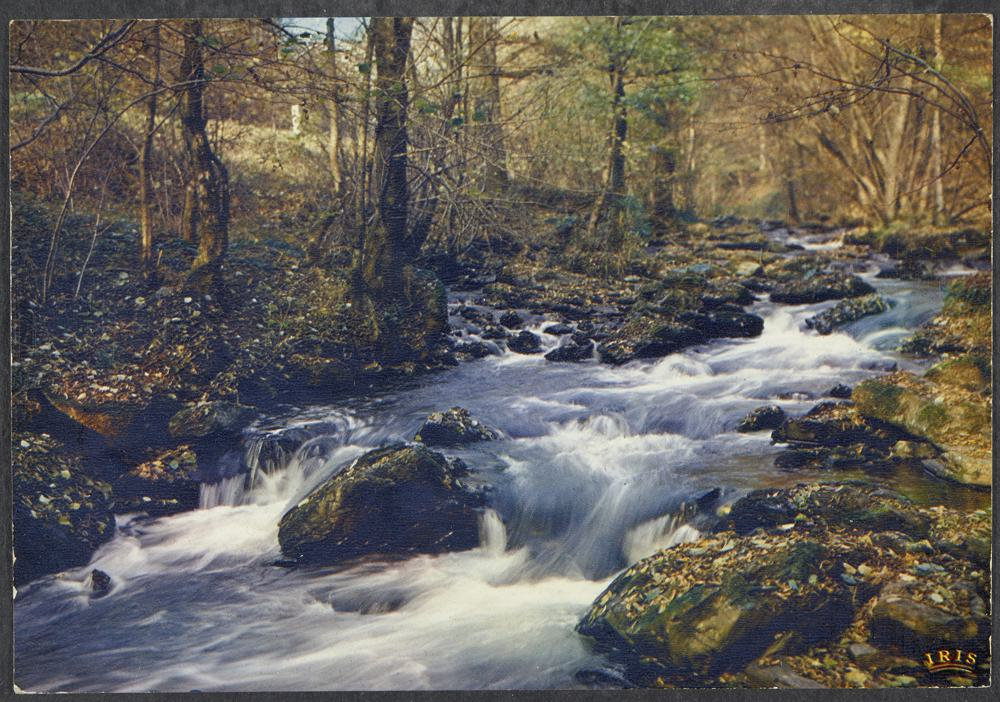

/scratch/leuven/338/vsc33847/DATASET_3/IE11100162/REP11100175/FL11100178_DIGI_0020_072045_R.tif.LQ.small.jpg


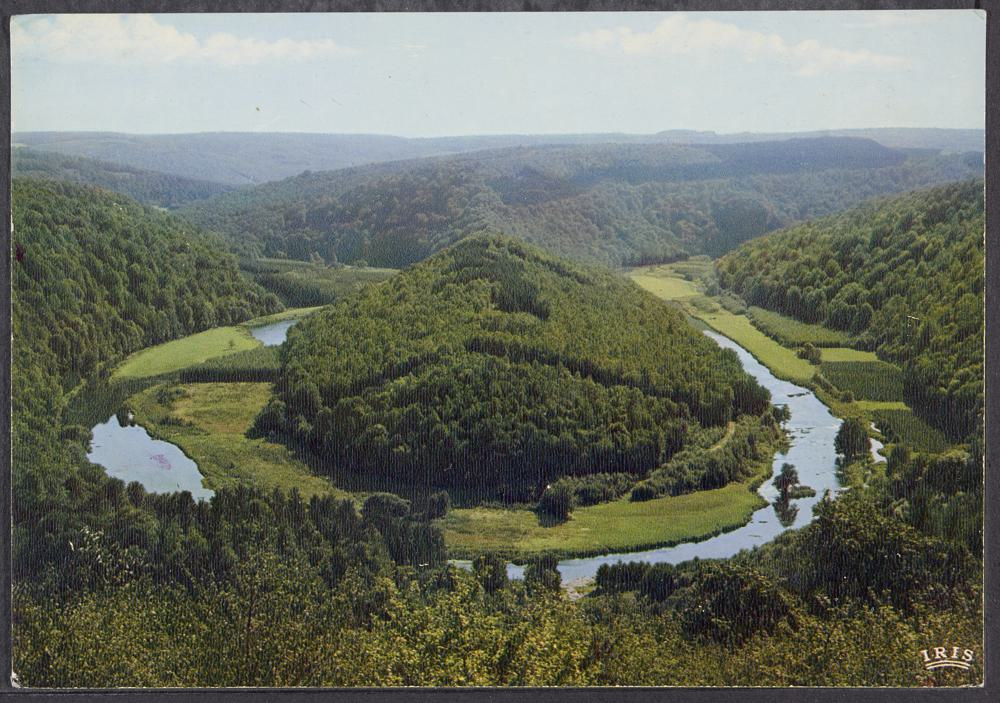

/scratch/leuven/338/vsc33847/DATASET_3/IE2811134/REP2811135/FL2811136_30137_DIGI_0020_05554_R_VIEW_MAIN.small.jpg


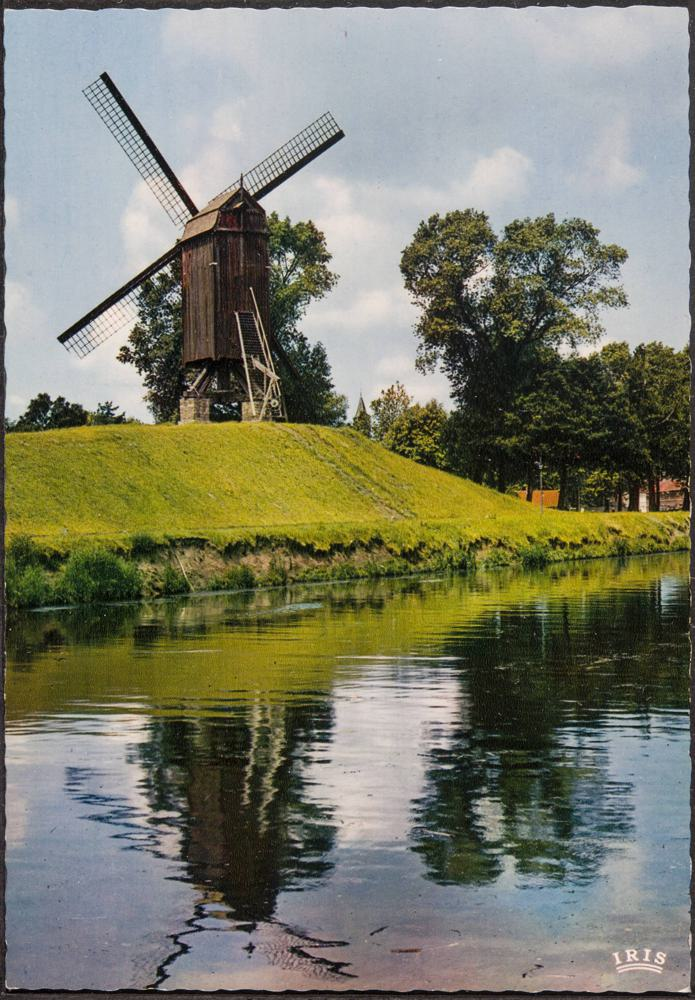

/scratch/leuven/338/vsc33847/DATASET_3/IE13958683/REP13958691/FL13958692_DIGI_0020_086339_R.tif.LQ.small.jpg


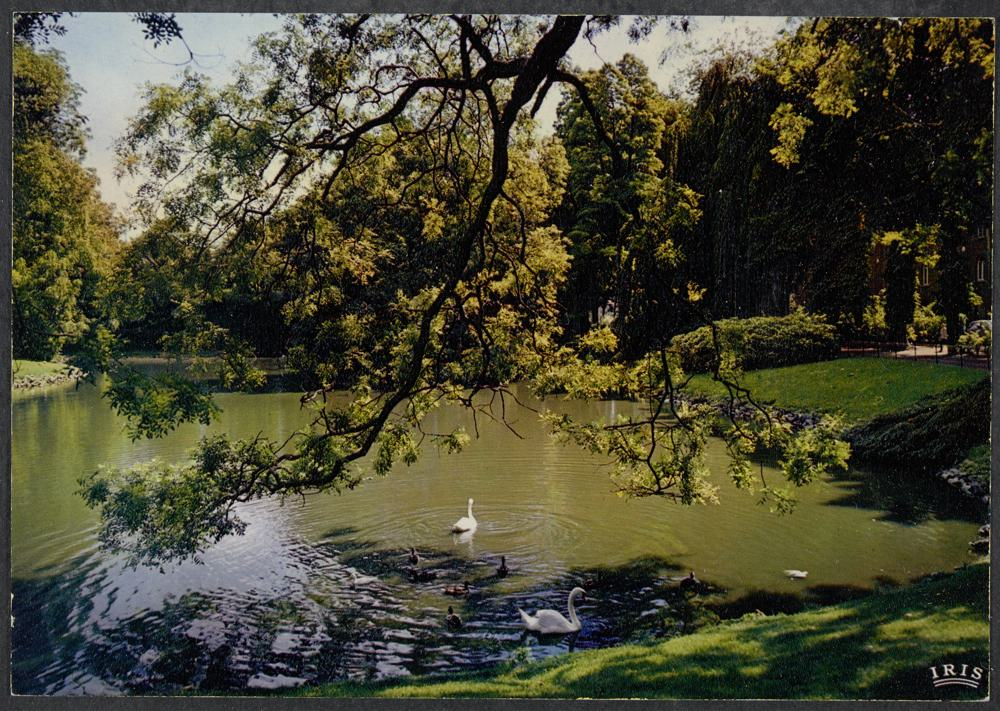

/scratch/leuven/338/vsc33847/DATASET_3/IE12383051/REP12383059/FL12383062_DIGI_0020_077057_R.tif.LQ.small.jpg


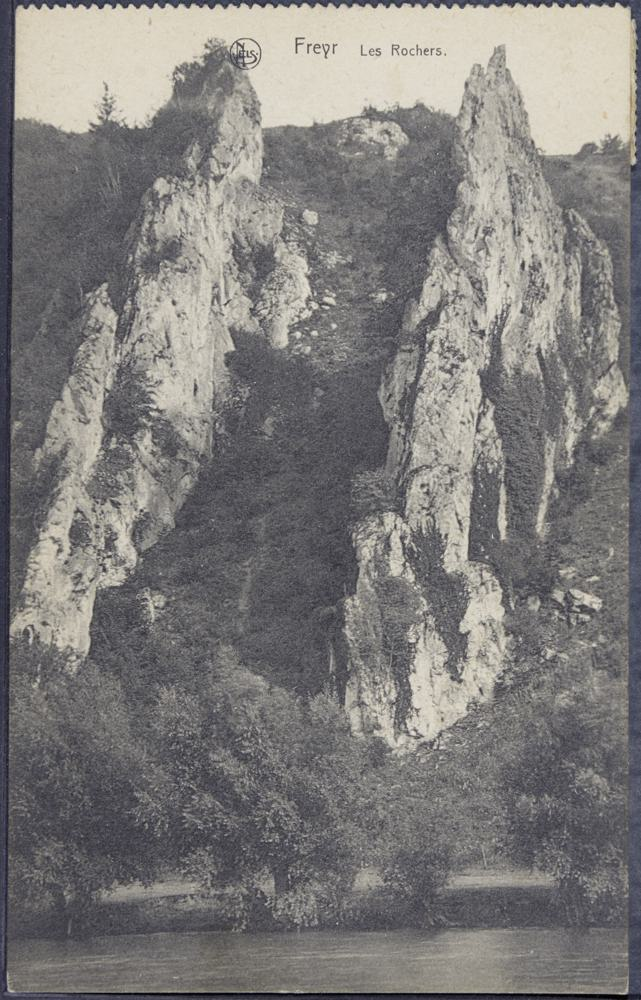

/scratch/leuven/338/vsc33847/DATASET_3/IE13985141/REP13985145/FL13985146_DIGI_0020_111167_R.tif.LQ.small.jpg


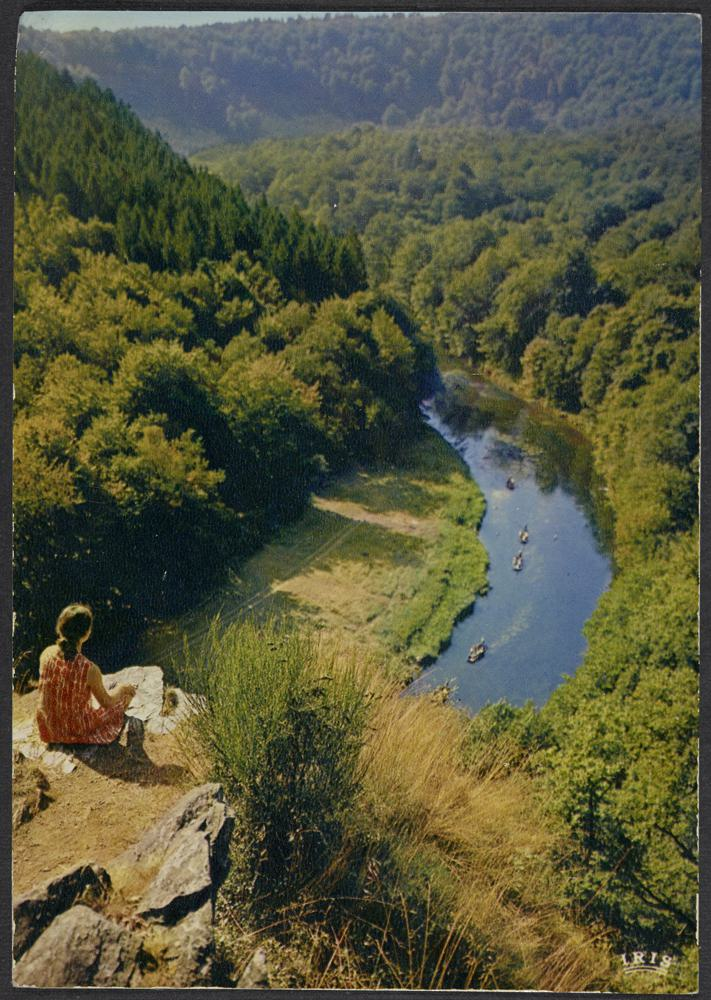

/scratch/leuven/338/vsc33847/DATASET_3/IE12382790/REP12382798/FL12382800_DIGI_0020_077027_R.tif.LQ.small.jpg


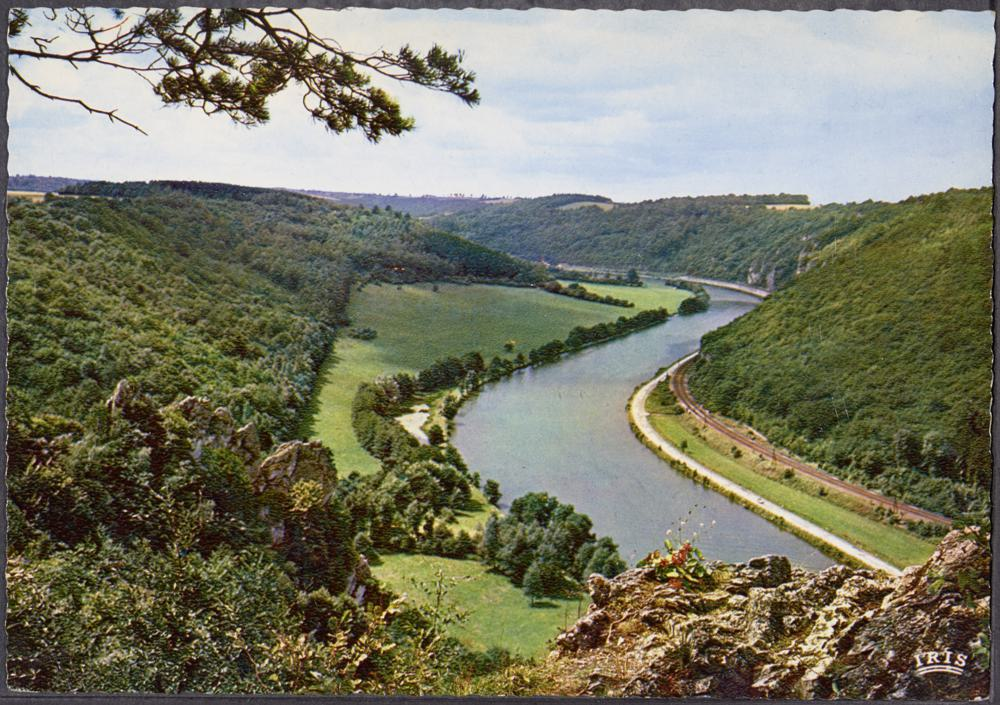

/scratch/leuven/338/vsc33847/DATASET_3/IE10543980/REP10543993/FL10543995_DIGI_0020_067320_R.tif.LQ.small.jpg


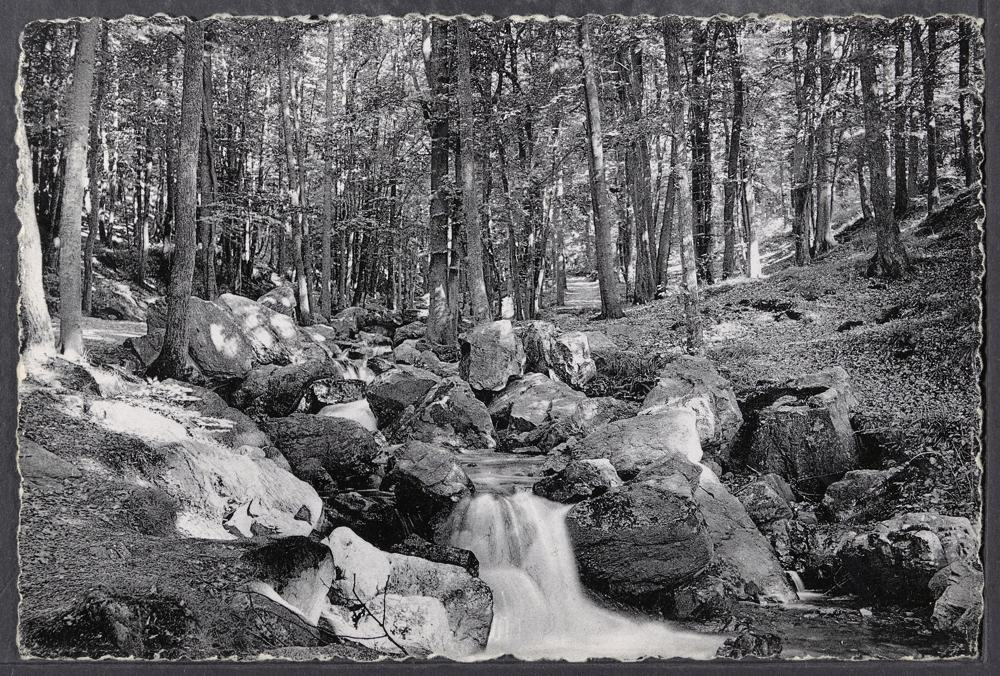

In [10]:
search("beautiful nature", k = 10)

Query:


'a huge crowd'

/scratch/leuven/338/vsc33847/DATASET_3/IE2823209/REP2823210/FL2823211_33587_DIGI_0020_08980_R_VIEW_MAIN.small.jpg


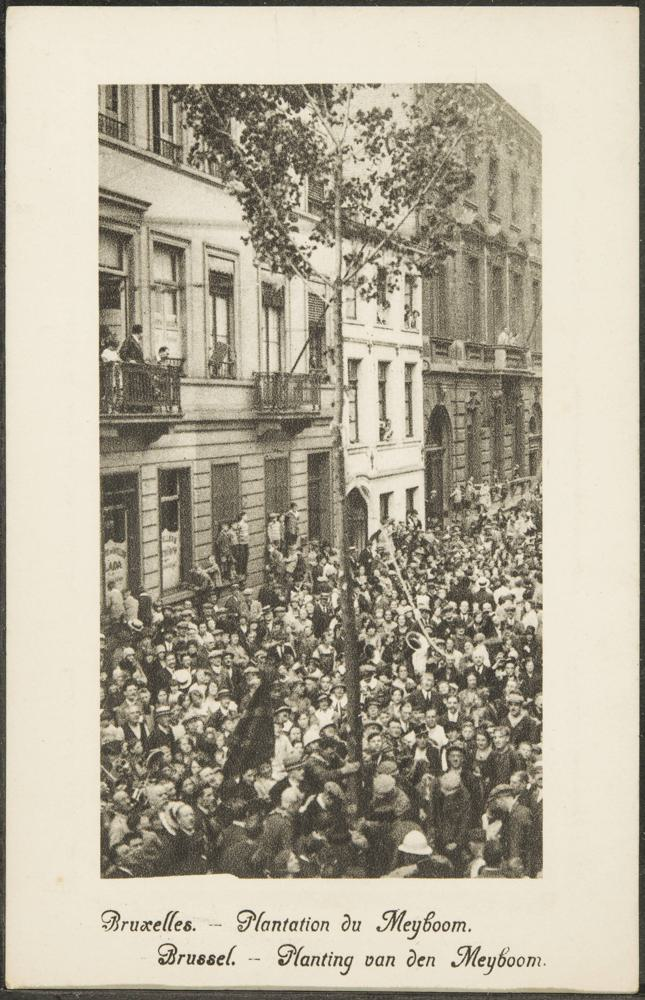

/scratch/leuven/338/vsc33847/DATASET_3/IE5904572/REP5904593/FL5904594_DIGI_0020_16104_R.Low.small.jpg


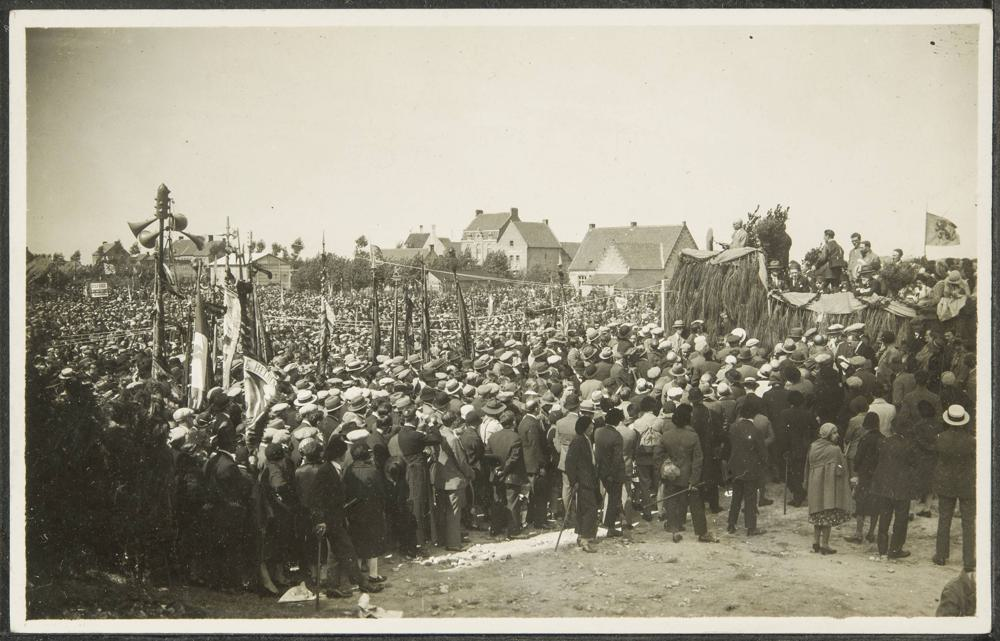

/scratch/leuven/338/vsc33847/DATASET_3/IE10092084/REP10092088/FL10092089_DIGI_0020_050278_R.tif.LQ.small.jpg


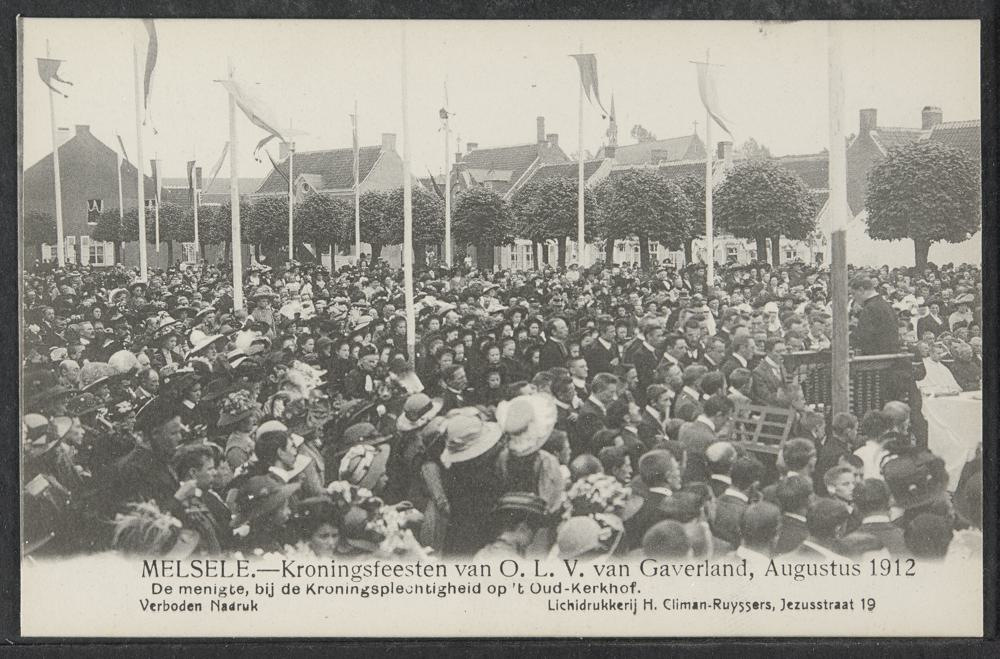

/scratch/leuven/338/vsc33847/DATASET_3/IE9081809/REP9081816/FL9081817_DIGI_0020_07222_R.tif.LQ.small.jpg


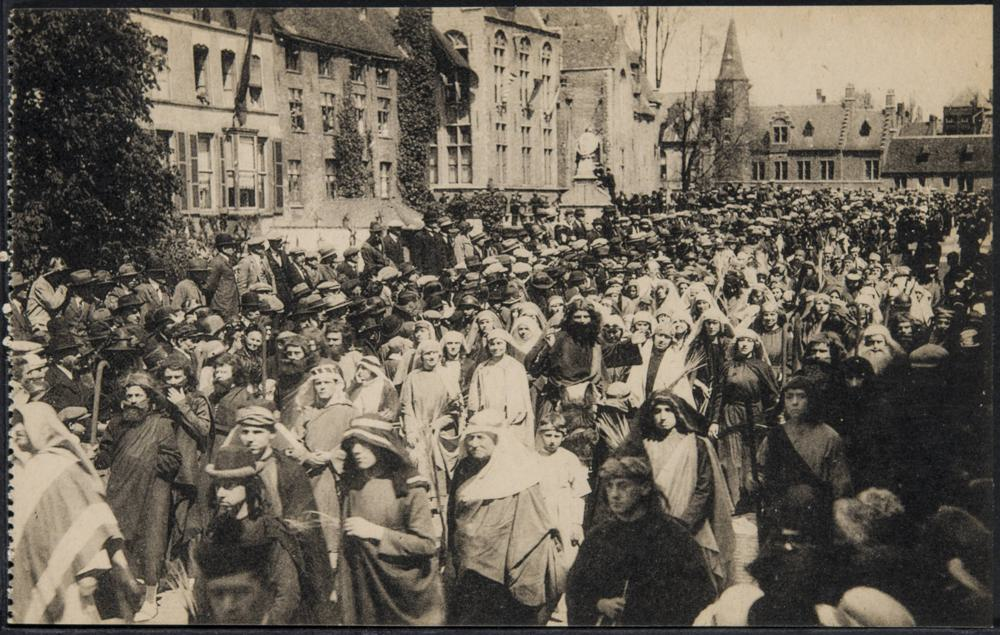

/scratch/leuven/338/vsc33847/DATASET_3/IE2780229/REP2780230/FL2780231_1939_DIGI_0020_01050_R_VIEW_MAIN.small.jpg


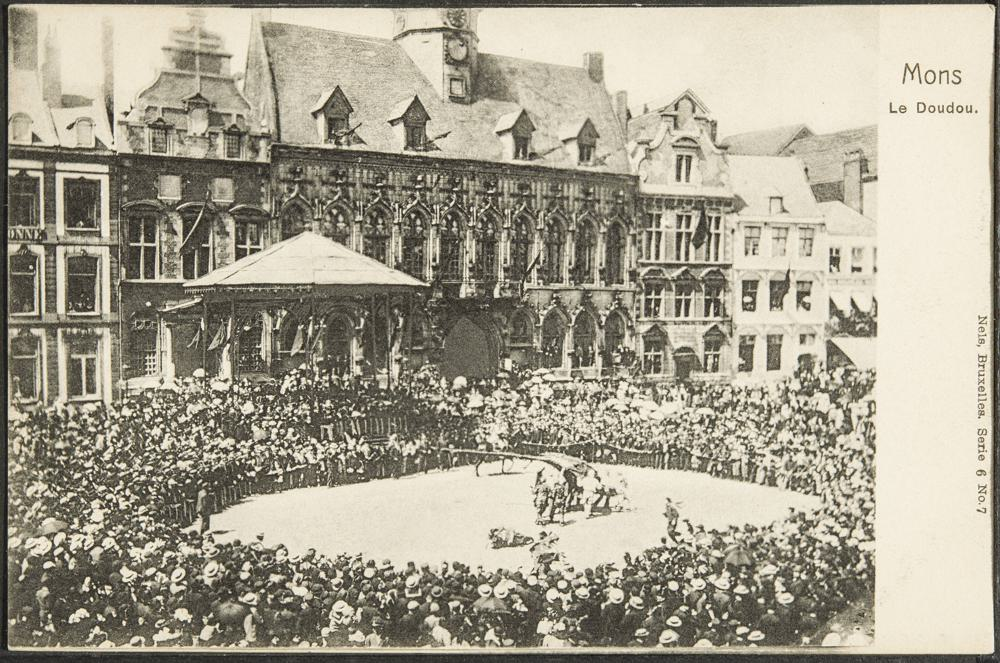

/scratch/leuven/338/vsc33847/DATASET_3/IE15523392/REP15523396/FL15523397_DIGI_0020_090513_R.tif.LQ.small.jpg


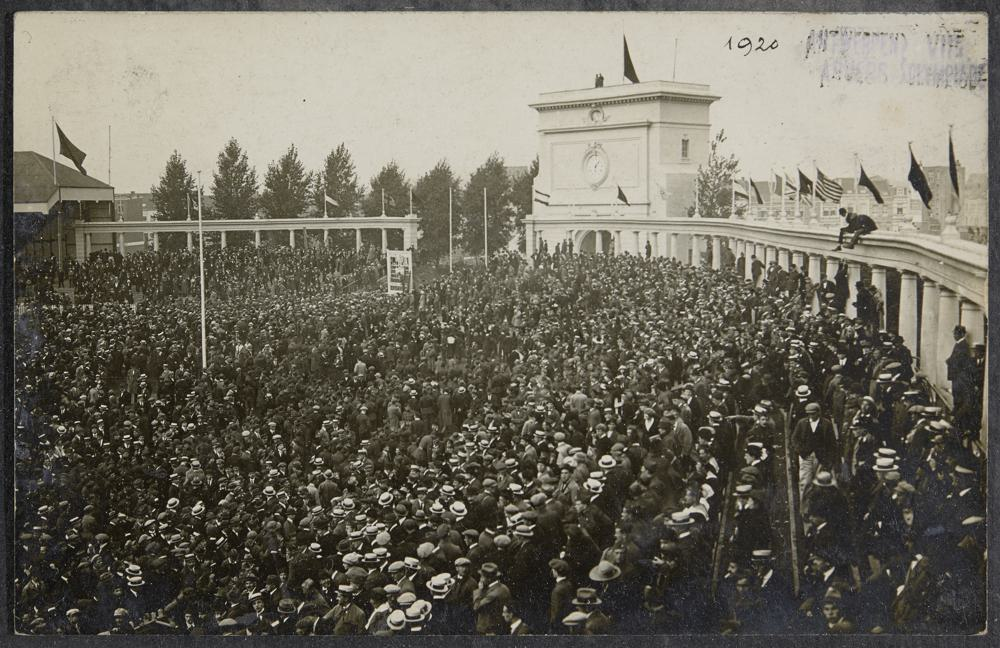

/scratch/leuven/338/vsc33847/DATASET_3/IE15519396/REP15519400/FL15519401_DIGI_0020_090069_R.tif.LQ.small.jpg


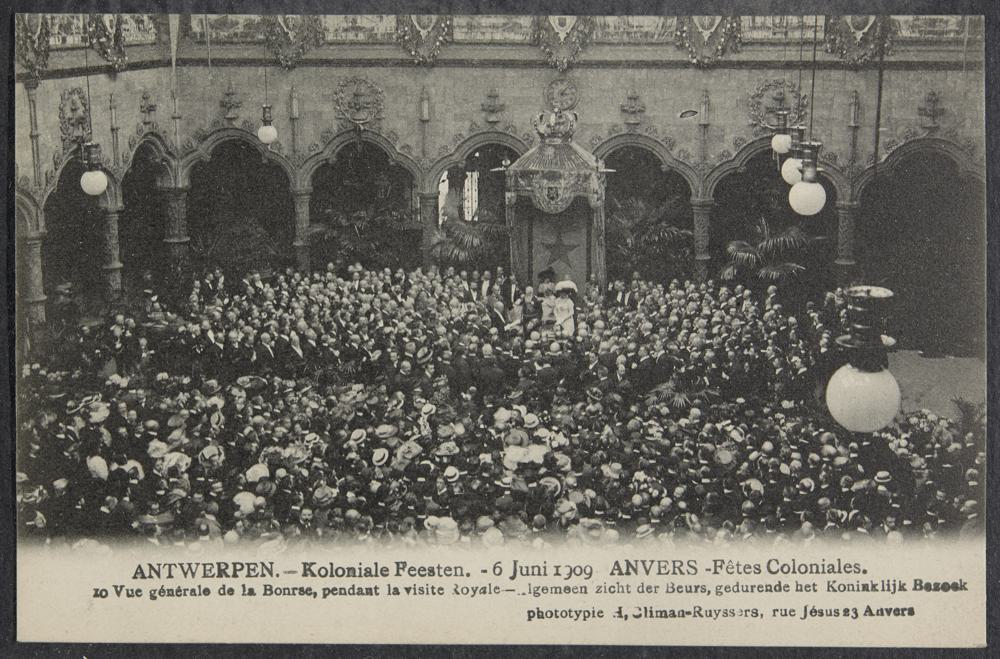

/scratch/leuven/338/vsc33847/DATASET_3/IE2780236/REP2780237/FL2780238_1941_DIGI_0020_01051_R_VIEW_MAIN.small.jpg


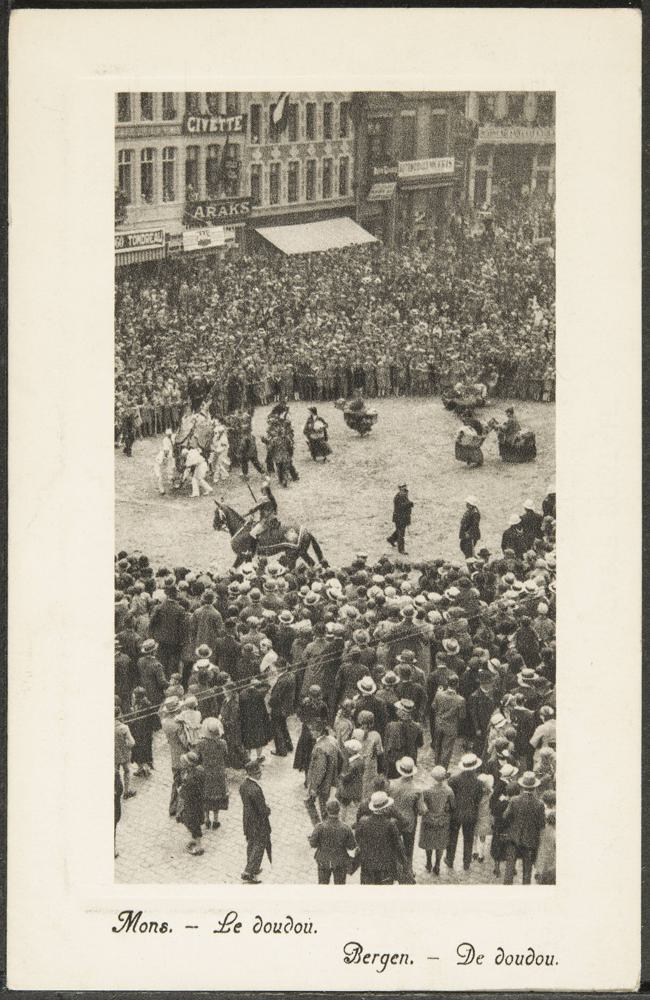

/scratch/leuven/338/vsc33847/DATASET_3/IE2778934/REP2778935/FL2778936_1569_DIGI_0020_00862_R_VIEW_MAIN.small.jpg


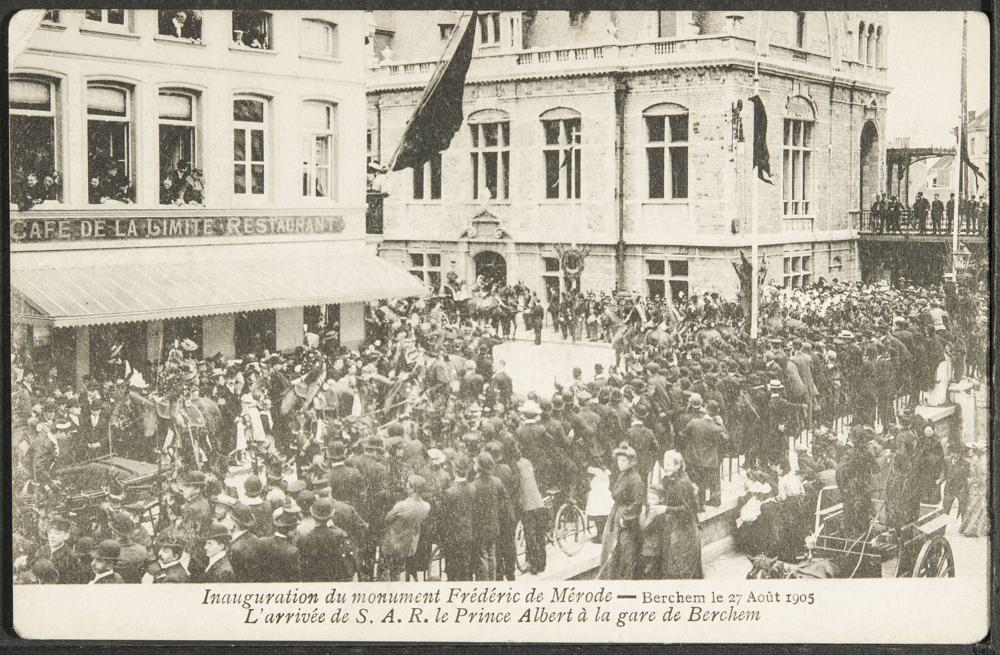

/scratch/leuven/338/vsc33847/DATASET_3/IE15523428/REP15523432/FL15523433_DIGI_0020_090517_R.tif.LQ.small.jpg


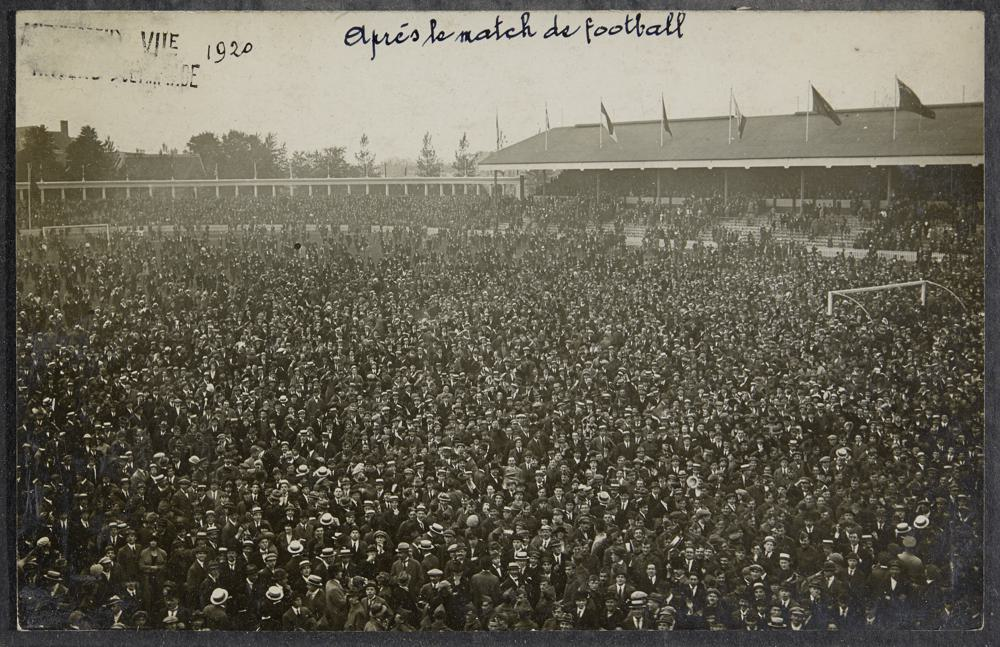

In [11]:
search("a huge crowd", k = 10)